In [1]:
!pip install -U lightautoml

     |████████████████████████████████| 262 kB 5.4 MB/s 
     |████████████████████████████████| 302 kB 39.4 MB/s 
     |████████████████████████████████| 204 kB 69.8 MB/s 
     |████████████████████████████████| 98 kB 5.8 MB/s 
     |████████████████████████████████| 67.4 MB 29 kB/s 
     |████████████████████████████████| 2.8 MB 33.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.1 MB/s 
     |████████████████████████████████| 232 kB 65.6 MB/s 
     |████████████████████████████████| 24.1 MB 2.8 kB/s 
     |████████████████████████████████| 424 kB 54.0 MB/s 
     |████████████████████████████████| 804.1 MB 2.5 kB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 2.8 MB 42.7 MB/s 
     |████████████████████████████████| 3.3 MB 38.8 MB/s 
     |████████████████████████████████| 636 kB 70.3 MB/s 
     |████████████████████████████████| 895 kB 52.9 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |██████████████

In [2]:
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import matplotlib.pyplot as plt


In [57]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 1500 # Time in seconds for automl run
TARGET_NAME = 'per_square_meter_price' # Target column name

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
%%time
train_data = pd.read_csv("/content/drive/MyDrive/RAIF HACK/data-20210924T160907Z-001/data/train.csv", index_col = "id")

[2021-09-26 03:36:25,408] (WARNING): <string>:2: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.




CPU times: user 2.33 s, sys: 282 ms, total: 2.61 s
Wall time: 2.77 s


In [60]:
train_data.head()

,city,floor,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,per_square_meter_price,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
COL_0,Пермь,NaN,57.998207,56.292797,4,19,35,52,0,0,0,0,0,2,4,6,3.293470,Пермь,1055397.0,0.027732,3,6,17,34,0,0,1,1,0,0,1,2,2,3,4,0,0,1,0,0,0,0,1,2,0,1,2,4,4,11,20,28,269.024986,3.368385,0,0,0,0.002864,4,13,21,139937.500000,136,49,2503.0,765.0,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
COL_1,Шатура,NaN,55.574284,39.543835,3,24,37,59,0,0,0,1,0,2,2,6,43.950989,Орехово-Зуево,120184.0,0.089441,0,31,50,57,0,1,2,3,0,0,1,2,1,1,3,2,4,6,2,2,2,1,1,2,0,1,2,3,1,12,20,29,102.455451,1.476600,0,0,0,0.154661,4,10,11,60410.714286,146,37,1336.0,514.0,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
COL_2,Ярославль,NaN,57.619140,39.850525,1,30,67,128,0,0,1,1,0,3,6,11,2.676293,Ярославль,603961.0,0.200995,0,15,29,53,0,1,2,2,0,0,5,9,0,1,3,0,0,0,0,0,1,2,3,6,0,1,6,9,1,16,37,80,243.361937,1.455127,0,0,0,0.118275,9,13,21,45164.761264,105,27,1883.0,573.0,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0
COL_3,Новокузнецк,NaN,53.897083,87.108604,0,0,5,21,0,0,0,1,0,0,1,4,15.618563,Новокузнецк,552105.0,0.861400,0,0,0,5,0,0,0,0,0,0,0,1,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,4,11,295.633502,9.400855,0,0,0,1.036523,0,0,3,28805.263158,75,2,1801.0,54.0,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.0,S10148,2020-01-05,110,0
COL_4,Москва,NaN,55.802590,37.487110,1,23,64,153,0,1,1,1,0,8,14,26,9.995325,Химки,232066.0,0.236744,0,14,40,78,0,0,0,0,0,0,3,9,2,7,14,0,2,2,1,1,3,3,4,9,0,8,8,12,0,8,33,89,1.110429,1.235503,0,0,0,0.235032,10,32,62,13222.591362,144,38,3090.0,619.0,7.263889,5.684211,1963.229167,1960.500000,Москва,60.2,S1338,2020-01-05,10,0


In [61]:
test_data = pd.read_csv("/content/drive/MyDrive/RAIF HACK/data-20210924T160907Z-001/data/test.csv", index_col = "id")
test_data.head()

,city,floor,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
COL_289284,Курск,1.0,7,55,85,117,0,0,0,0,0,2,6,10,4.101661,Курск,443212.0,0.147072,0,7,7,19,0,0,0,0,1,2,3,3,5,5,5,2,2,4,7,7,8,0,0,1,0,0,0,1,5,36,61,83,435.363535,5.636811,0,0,0,0.108668,11,15,27,184,78,1997.0,743.0,4.325000,4.211268,1966.471591,1966.740260,Курская область,51.709255,36.147908,156.148996,S6983,2020-09-06,100,1
COL_289305,Сургут,1.0,8,70,112,140,0,0,0,0,0,7,8,13,4.084249,Сургут,380632.0,0.162480,0,18,33,50,0,0,0,1,1,2,5,6,3,6,8,1,1,1,3,5,5,3,6,7,0,3,5,8,4,51,81,99,693.447931,9.641591,0,0,0,0.091416,9,11,19,118,44,2823.0,1019.0,5.389831,5.500000,1988.259259,1989.068182,Ханты-Мансийский АО,61.233240,73.462509,190.737943,S29120,2020-09-06,110,1
COL_289318,Тюмень,-1.0,3,28,67,122,0,0,0,0,0,9,18,34,1.291974,Тюмень,744554.0,0.075807,1,21,57,92,0,0,1,2,0,1,4,5,2,3,3,1,2,5,0,1,1,0,2,5,0,1,1,3,3,15,34,63,298.904686,1.803999,0,0,0,0.120308,6,20,29,150,51,3484.0,1332.0,7.915493,8.250000,1985.880282,1991.458333,Тюменская область,57.143110,65.554573,457.118051,S23731,2020-09-06,10,1
COL_289354,Иркутск,1.0,5,76,139,231,0,0,0,0,0,28,52,84,0.914598,Иркутск,623562.0,0.043604,1,30,60,95,1,8,13,18,0,5,6,10,5,8,12,12,20,32,1,8,18,1,5,5,0,7,11,16,3,14,26,51,60.224709,1.338052,0,0,0,0.079332,9,18,29,252,86,1975.0,666.0,3.276860,3.012048,1947.073276,1941.657895,Иркутская область,52.281380,104.282975,66.503622,S14207,2020-09-06,100,1
COL_289399,Курск,NaN,8,105,189,279,0,0,2,9,1,24,40,54,1.300135,Курск,443212.0,0.084204,1,40,72,84,1,10,12,12,3,10,14,21,2,6,6,10,14,17,1,1,1,4,5,12,0,2,12,16,1,49,98,156,432.530106,2.440972,0,0,0,0.093642,12,26,37,114,31,1044.0,394.0,4.346154,4.827586,1948.764151,1946.689655,Курская область,51.729706,36.194019,23.864915,S20658,2020-09-06,10,1


In [62]:
submission_data = pd.read_csv("/content/drive/MyDrive/RAIF HACK/data-20210924T160907Z-001/data/test_submission.csv")
submission_data.head()

,id,per_square_meter_price
0,COL_289284,0
1,COL_289305,0
2,COL_289318,0
3,COL_289354,0
4,COL_289399,0


In [63]:
train_data = train_data[train_data['price_type'] == 1]
train_data

,city,floor,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,per_square_meter_price,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
COL_62,Красноярск,NaN,56.063615,92.958428,0,7,14,26,0,0,0,0,0,0,0,2,7.795659,Красноярск,1095286.0,0.041323,2,6,25,35,0,0,0,2,0,1,2,3,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,5,10,15,1.087101,2.281425,0,0,0,0.052809,7,15,21,103120.697310,95,31,2670.0,940.0,7.136842,7.612903,1976.684211,1980.483871,Красноярский край,106.351104,S5845,2020-01-05,110,1
COL_71,Саратов,NaN,51.534581,46.020549,13,198,345,462,0,0,0,0,4,44,66,89,0.987160,Саратов,842097.0,0.144936,0,4,34,59,0,1,6,9,0,13,22,27,7,17,27,4,7,9,2,5,7,11,16,20,1,11,21,28,8,125,218,286,357.425239,1.924421,0,0,0,0.045451,22,34,45,24874.371004,502,104,4886.0,943.0,4.144608,4.164557,1940.591549,1939.348837,Саратовская область,175.039602,S27968,2020-01-05,10,1
COL_140,Красноярск,NaN,56.026884,92.818323,3,15,23,33,0,0,0,0,0,1,3,4,3.730568,Красноярск,1095286.0,0.141526,0,16,35,56,0,0,0,0,2,3,3,3,0,1,1,3,3,3,0,0,1,2,2,2,0,2,2,3,1,5,10,18,1.621353,0.579096,0,0,2,0.223787,6,11,18,80058.148547,175,66,4282.0,1445.0,6.851429,5.742424,1976.714286,1972.878788,Красноярский край,89.534921,S23597,2020-01-05,10,1
COL_202,Иркутск,NaN,52.275528,104.251444,0,10,26,40,0,1,1,1,0,2,6,8,2.344310,Иркутск,623562.0,0.281491,0,6,6,6,0,0,0,0,0,0,0,1,0,4,4,0,0,0,0,1,2,1,2,2,0,1,1,1,0,5,11,21,61.562546,0.813594,0,0,2,0.266067,8,11,19,24649.765045,230,56,1887.0,612.0,4.597222,5.469388,1968.098131,1975.530612,Иркутская область,419.557752,S10587,2020-01-05,10,1
COL_207,Белгород,NaN,50.576545,36.584197,4,48,73,92,0,0,6,6,1,7,11,15,2.170184,Белгород,384425.0,0.065996,1,19,28,46,1,5,10,11,0,2,2,4,3,3,4,2,2,2,0,2,2,10,11,15,0,0,0,0,1,19,29,36,555.411948,2.505330,0,0,0,0.092583,7,17,22,39135.228322,131,35,3837.0,1073.0,9.157480,9.088235,1983.125984,1980.470588,Белгородская область,1098.703185,S11220,2020-01-05,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [64]:
import re

_float_regexp = re.compile(r"^[-+]?(?:\b[0-9]+(?:\.[0-9]*)?|\.[0-9]+\b)(?:[eE][-+]?[0-9]+\b)?$").match
default_floors = set([str(i) for i in range(-2, 11)])

def is_float_re(str):
    return True if _float_regexp(str) else False

def map_floor(x):
    if is_float_re(x):
        res = x
    elif 'оль' in x:
        res = '-1'
    elif set.intersection(default_floors, set(x.split(","))):
        res = '999'
    else:
        res = '998'
    return res

def city_type(row):
    if row >=1000000:
        return "1Million"
    elif  (row<1000000)&(row >200000):
        return "Medium"
    else:
        return "Small"

zarplaty = pd.read_excel('/content/drive/MyDrive/RAIF HACK/zarplaty.xlsx')
city_population = pd.read_csv('/content/drive/MyDrive/RAIF HACK/city_population.csv')
budget = pd.read_excel('/content/drive/MyDrive/RAIF HACK/RF_budget.xlsx')

def preprocess_data(df):
    
    # nan-floor to 0 and float
    df['floor'] = df['floor'].astype(str)
    df['floor'] = df['floor'].apply(lambda x: float(map_floor(x)))
    
    # string columns fill with 'missing'
    df['street'] = df['street'].fillna('missing')
    df['city'] = df['city'].fillna('missing')
    df['region'] = df['region'].fillna('missing')

    df.city = df.city.apply(lambda x: x.lower())
    city_population_clean = city_population.groupby('settlement').agg({'population':'sum'}).reset_index()
    city_population_clean.columns = ['city', 'city_population']
    city_population_clean['city_population']
    city_population_clean.city = city_population_clean.city.apply(lambda x: x.lower())
    df = df.merge(city_population_clean, on = 'city', how='left')

    df.region = df.region.apply(lambda x: x.lower())
    budget.region = budget.region.apply(lambda x: x.lower())
    df = df.merge(budget, on = 'region', how='left')
    df.region_income = df.region_income * 10**9
    df.region_outcome = df.region_outcome * 10**9

    df['city_type'] = df['city_population'].apply(lambda x: city_type(x))
    df.loc[df.city  == 'москва', 'city_type'] = "Msk"
    df.loc[df.city  == 'санкт-Петербург', 'city_type'] = "Spb"

    df = df.merge(zarplaty, on='region', how='left')
    df['zarplata'] = pd.to_numeric(df['zarplata'], downcast = 'unsigned')

    # fill other numeric columns with 0
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(0)
    
    return df

In [65]:
%%time

def create_expert_feats(data):
    # we had error with date format, so we will convert it to needed format and for some not parseable values to NaT
    data['date'] = pd.to_datetime(data['date'].astype(str), errors='coerce')
    # and now we split day, month and year and make new columns
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    #data['year'] = data['date'].dt.year
    # then drop out old column
    data.drop(['date'], axis = 1, inplace = True)

    data = preprocess_data(data)

    return data

train_data = create_expert_feats(train_data)
test_data = create_expert_feats(test_data)

CPU times: user 693 ms, sys: 7.08 ms, total: 700 ms
Wall time: 704 ms


In [66]:
'region_income' in train_data

True

In [67]:
train_data.head()

,city,floor,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,...,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,per_square_meter_price,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,realty_type,price_type,day,month,city_population,region_income,region_outcome,city_type,zarplata
0,красноярск,998.0,56.063615,92.958428,0,7,14,26,0,0,0,0,0,0,0,2,7.795659,Красноярск,1095286.0,0.041323,2,6,25,35,0,0,0,2,0,1,2,3,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,5,10,15,1.087101,2.281425,0,0,0,0.052809,7,15,21,103120.697310,95,31,2670.0,940.0,7.136842,7.612903,1976.684211,1980.483871,красноярский край,106.351104,S5845,110,1,5,1,1067030.0,2.486000e+11,2.546000e+11,1Million,0.0
1,саратов,998.0,51.534581,46.020549,13,198,345,462,0,0,0,0,4,44,66,89,0.987160,Саратов,842097.0,0.144936,0,4,34,59,0,1,6,9,0,13,22,27,7,17,27,4,7,9,2,5,...,16,20,1,11,21,28,8,125,218,286,357.425239,1.924421,0,0,0,0.045451,22,34,45,24874.371004,502,104,4886.0,943.0,4.144608,4.164557,1940.591549,1939.348837,саратовская область,175.039602,S27968,10,1,5,1,840785.0,1.084000e+11,1.114000e+11,Medium,0.0
2,красноярск,998.0,56.026884,92.818323,3,15,23,33,0,0,0,0,0,1,3,4,3.730568,Красноярск,1095286.0,0.141526,0,16,35,56,0,0,0,0,2,3,3,3,0,1,1,3,3,3,0,0,...,2,2,0,2,2,3,1,5,10,18,1.621353,0.579096,0,0,2,0.223787,6,11,18,80058.148547,175,66,4282.0,1445.0,6.851429,5.742424,1976.714286,1972.878788,красноярский край,89.534921,S23597,10,1,5,1,1067030.0,2.486000e+11,2.546000e+11,1Million,0.0
3,иркутск,998.0,52.275528,104.251444,0,10,26,40,0,1,1,1,0,2,6,8,2.344310,Иркутск,623562.0,0.281491,0,6,6,6,0,0,0,0,0,0,0,1,0,4,4,0,0,0,0,1,...,2,2,0,1,1,1,0,5,11,21,61.562546,0.813594,0,0,2,0.266067,8,11,19,24649.765045,230,56,1887.0,612.0,4.597222,5.469388,1968.098131,1975.530612,иркутская область,419.557752,S10587,10,1,5,1,623479.0,1.805000e+11,1.889000e+11,Medium,0.0
4,белгород,998.0,50.576545,36.584197,4,48,73,92,0,0,6,6,1,7,11,15,2.170184,Белгород,384425.0,0.065996,1,19,28,46,1,5,10,11,0,2,2,4,3,3,4,2,2,2,0,2,...,11,15,0,0,0,0,1,19,29,36,555.411948,2.505330,0,0,0,0.092583,7,17,22,39135.228322,131,35,3837.0,1073.0,9.157480,9.088235,1983.125984,1980.470588,белгородская область,1098.703185,S11220,10,1,5,1,378390.0,9.750000e+10,1.039000e+11,Medium,0.0


In [68]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

cat_columns = ['city', 'city_type', 'day', 'month', 
               'price_type', 'realty_type', 'street', 'region',
               'osm_city_nearest_name', 'per_square_meter_price']

features_to_scale = list(set.difference(set(train_data.columns), set(cat_columns)))

scaler = StandardScaler()

train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale].to_numpy())
test_data[features_to_scale] = scaler.transform(test_data[features_to_scale].to_numpy())
train_data

,city,floor,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,...,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,per_square_meter_price,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,realty_type,price_type,day,month,city_population,region_income,region_outcome,city_type,zarplata
0,красноярск,0.849340,0.164035,1.088081,-0.707039,-0.646452,-0.636452,-0.615489,-0.124043,-0.177987,-0.225217,-0.256666,-0.430825,-0.504393,-0.496675,-0.472681,-0.025182,Красноярск,-0.100639,-0.400206,0.621112,-0.804827,-0.408153,-0.543837,-0.260735,-0.381556,-0.423549,-0.362255,-0.406682,-0.525497,-0.557302,-0.594429,-0.653675,-0.691903,-0.688266,-0.580907,-0.642265,-0.606928,-0.332051,-0.339311,...,-0.559389,-0.640775,-0.399712,-0.509145,-0.506401,-0.501015,-0.616443,-0.590805,-0.591813,-0.592577,-0.657728,-0.329392,-0.11633,-0.165719,-0.224833,-0.439076,-0.105900,-0.035932,-0.264321,103120.697310,-0.644927,-0.520526,0.014155,0.335535,0.392156,0.451655,0.178040,0.198712,красноярский край,-0.285497,S5845,110,1,5,1,-0.116465,0.048312,0.019612,1Million,0.0
1,саратов,0.849340,-1.140184,-0.616391,1.803748,1.677311,1.292408,0.926510,-0.124043,-0.177987,-0.225217,-0.256666,1.380778,0.912025,0.525386,0.361289,-0.235966,Саратов,-0.235960,-0.067584,-0.628902,-0.940652,-0.098849,-0.038803,-0.260735,-0.235792,0.025397,-0.026388,-0.406682,2.560516,2.267879,1.615407,1.160864,1.510383,1.415287,0.389539,0.210123,0.007643,-0.123830,-0.080276,...,1.650847,1.101628,0.637784,0.534550,0.453875,0.275203,1.707357,1.900425,1.541012,1.114016,0.482937,-0.343254,-0.11633,-0.165719,-0.224833,-0.469736,2.654012,1.940490,1.345885,24874.371004,3.671101,1.944702,1.505166,0.342103,-0.721869,-0.658094,0.020789,0.037900,саратовская область,-0.221979,S27968,10,1,5,1,-0.225959,-0.295668,-0.293711,Medium,0.0
2,красноярск,0.849340,0.153457,1.082993,-0.127626,-0.549122,-0.584006,-0.590732,-0.124043,-0.177987,-0.225217,-0.256666,-0.430825,-0.472201,-0.450218,-0.453509,-0.151033,Красноярск,-0.100639,-0.078533,-0.628902,-0.125698,-0.064481,-0.101932,-0.260735,-0.381556,-0.423549,-0.458217,3.110586,-0.011161,-0.416043,-0.594429,-0.653675,-0.562357,-0.610357,0.146928,-0.276956,-0.453285,-0.332051,-0.339311,...,-0.412040,-0.549069,-0.399712,-0.319383,-0.414946,-0.417849,-0.325968,-0.590805,-0.591813,-0.573685,-0.656018,-0.395490,-0.1163

In [69]:
import typing

THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_vec(y_true: np.array, y_pred: np.array) -> float:
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    
    metr = deviation * 0.0 + 9
    
    metr[np.abs(deviation) <= THRESHOLD] = 0
    
    metr[deviation <= - 4 * THRESHOLD] = 9 * NEGATIVE_WEIGHT
    
    mask = (-4 * THRESHOLD < deviation) & (deviation < -THRESHOLD)
    metr[mask] = NEGATIVE_WEIGHT * ((deviation[mask] / THRESHOLD) + 1) ** 2
    
    mask = (deviation < 4 * THRESHOLD) & (deviation > THRESHOLD)
    metr[mask] = ((deviation[mask] / THRESHOLD) - 1) ** 2
    
    return metr.mean()

In [70]:
%%time

#task = Task('reg')#, metric = deviation_metric)
task = Task('reg', loss='rmsle', metric=deviation_metric_vec, greater_is_better=False)

CPU times: user 210 µs, sys: 5 µs, total: 215 µs
Wall time: 222 µs


In [71]:
%%time
roles = {'target': TARGET_NAME,
  #       'drop': ['floor'] # to drop or not to drop?
         }

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [72]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['lgb_tuned', 'cb_tuned']]},
                       tuning_params={'max_tuning_iter': 5},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'cv': 5, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['lgb_tuned', 'cb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 1499.9824378490448 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (4493, 82)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1489.3693697452545 secs
Optuna may run 312.3712479170163 secs


[2021-09-26 03:39:10,594] (INFO): A new study created in memory with name: no-name-fd5a45cb-6b0c-4ee8-8c3f-ac37501aa102


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.168532	valid's Opt metric: 2.29434
[200]	valid's l2: 0.13297	valid's Opt metric: 1.88604
[300]	valid's l2: 0.12303	valid's Opt metric: 1.73052
[400]	valid's l2: 0.119676	valid's Opt metric: 1.66693
[500]	valid's l2: 0.118531	valid's Opt metric: 1.64138
[600]	valid's l2: 0.11799	valid's Opt metric: 1.62613
[700]	valid's l2: 0.117801	valid's Opt metric: 1.61771
[800]	valid's l2: 0.117866	valid's Opt metric: 1.61526
[900]	valid's l2: 0.117883	valid's Opt metric: 1.6102
Early stopping, best iteration is:
[700]	valid's l2: 0.117801	valid's Opt metric: 1.61771
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:39:23,770] (INFO): Trial 0 finished with value: -1.6177113514983503 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.6177113514983503.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.167974	valid's Opt metric: 2.29408
[200]	valid's l2: 0.132038	valid's Opt metric: 1.8706
[300]	valid's l2: 0.123582	valid's Opt metric: 1.71568
[400]	valid's l2: 0.120437	valid's Opt metric: 1.66026
[500]	valid's l2: 0.119183	valid's Opt metric: 1.63649
[600]	valid's l2: 0.118571	valid's Opt metric: 1.61922
[700]	valid's l2: 0.118463	valid's Opt metric: 1.6106
[800]	valid's l2: 0.118544	valid's Opt metric: 1.60361
Early stopping, best iteration is:
[684]	valid's l2: 0.118424	valid's Opt metric: 1.61069
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:39:39,104] (INFO): Trial 1 finished with value: -1.6106894310651345 and parameters: {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}. Best is trial 1 with value: -1.6106894310651345.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.169862	valid's Opt metric: 2.32425
[200]	valid's l2: 0.13353	valid's Opt metric: 1.92261
[300]	valid's l2: 0.123945	valid's Opt metric: 1.76426
[400]	valid's l2: 0.120197	valid's Opt metric: 1.70343
[500]	valid's l2: 0.118681	valid's Opt metric: 1.67891
[600]	valid's l2: 0.117703	valid's Opt metric: 1.65459
[700]	valid's l2: 0.117453	valid's Opt metric: 1.64182
[800]	valid's l2: 0.117435	valid's Opt metric: 1.63925
[900]	valid's l2: 0.117522	valid's Opt metric: 1.63455
[1000]	valid's l2: 0.117844	valid's Opt metric: 1.63765
Early stopping, best iteration is:
[821]	valid's l2: 0.117412	valid's Opt metric: 1.63809
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:39:50,030] (INFO): Trial 2 finished with value: -1.638087910864171 and parameters: {'feature_fraction': 0.5780093202212182, 'num_leaves': 53}. Best is trial 1 with value: -1.6106894310651345.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.169756	valid's Opt metric: 2.32609
[200]	valid's l2: 0.133637	valid's Opt metric: 1.92765
[300]	valid's l2: 0.123857	valid's Opt metric: 1.75976
[400]	valid's l2: 0.120082	valid's Opt metric: 1.69544
[500]	valid's l2: 0.118452	valid's Opt metric: 1.66566
[600]	valid's l2: 0.117632	valid's Opt metric: 1.64862
[700]	valid's l2: 0.117414	valid's Opt metric: 1.63995
[800]	valid's l2: 0.11714	valid's Opt metric: 1.63131
[900]	valid's l2: 0.116969	valid's Opt metric: 1.62577
[1000]	valid's l2: 0.117089	valid's Opt metric: 1.62472
[1100]	valid's l2: 0.117178	valid's Opt metric: 1.62203
Early stopping, best iteration is:
[905]	valid's l2: 0.116913	valid's Opt metric: 1.62482
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:40:03,414] (INFO): Trial 3 finished with value: -1.6248151079371151 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223}. Best is trial 1 with value: -1.6106894310651345.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.168344	valid's Opt metric: 2.28825
[200]	valid's l2: 0.132994	valid's Opt metric: 1.88477
[300]	valid's l2: 0.123535	valid's Opt metric: 1.72238
[400]	valid's l2: 0.120467	valid's Opt metric: 1.66973
[500]	valid's l2: 0.119374	valid's Opt metric: 1.64412
[600]	valid's l2: 0.118923	valid's Opt metric: 1.63107
[700]	valid's l2: 0.118769	valid's Opt metric: 1.62247
[800]	valid's l2: 0.118678	valid's Opt metric: 1.6168
[900]	valid's l2: 0.118695	valid's Opt metric: 1.61337
[1000]	valid's l2: 0.118855	valid's Opt metric: 1.61223
Early stopping, best iteration is:
[859]	valid's l2: 0.118637	valid's Opt metric: 1.61475
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:40:20,577] (INFO): Trial 4 finished with value: -1.6147497203142482 and parameters: {'feature_fraction': 0.8005575058716043, 'num_leaves': 185}. Best is trial 1 with value: -1.6106894310651345.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.117179	valid's Opt metric: 1.67654
[200]	valid's l2: 0.116	valid's Opt metric: 1.63462
Early stopping, best iteration is:
[174]	valid's l2: 0.115473	valid's Opt metric: 1.62836

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0986118	valid's Opt metric: 1.20384
[200]	valid's l2: 0.0984589	valid's Opt metric: 1.19837
Early stopping, best iteration is:
[130]	valid's l2: 0.0982122	valid's Opt metric: 1.19117

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.101688	valid's Opt metric: 1.36402
[200]	valid's l2: 0.103074	valid's Opt metric: 1.35761
Early stopping, best iteration is:
[100]	v

[2021-09-26 03:40:42,665] (INFO): A new study created in memory with name: no-name-8b5567c5-08d5-43bf-aa37-82c2d2c2b0af


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5685180	test: 0.5898048	best: 0.5898048 (0)	total: 3.43ms	remaining: 6.86s
100:	learn: 0.3308841	test: 0.3593181	best: 0.3593181 (100)	total: 270ms	remaining: 5.08s
200:	learn: 0.3023332	test: 0.3477956	best: 0.3477956 (200)	total: 517ms	remaining: 4.62s
300:	learn: 0.2784463	test: 0.3438355	best: 0.3436631 (294)	total: 775ms	remaining: 4.37s
400:	learn: 0.2624242	test: 0.3422515	best: 0.3422515 (400)	total: 1.02s	remaining: 4.07s
500:	learn: 0.2493107	test: 0.3407956	best: 0.3406667 (494)	total: 1.29s	remaining: 3.85s
600:	learn: 0.2386804	test: 0.3400220	best: 0.3399017 (580)	total: 1.54s	remaining: 3.6s
700:	learn: 0.2288984	test: 0.3390621	best: 0.3390088 (661)	total: 1.8s	remaining: 3.33s
800:	learn: 0.2199985	test: 0.3386048	best: 0.3382795 (760)	total: 2.06s	remaining: 3.08s
900:	learn: 0.2119589	test: 0.3382663	best: 0.3381879 (897)	total: 2.31s	rema

[2021-09-26 03:40:48,062] (INFO): Trial 0 finished with value: -1.603681129583758 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.603681129583758.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5673738	test: 0.5892902	best: 0.5892902 (0)	total: 9.3ms	remaining: 18.6s
100:	learn: 0.2895642	test: 0.3514587	best: 0.3514587 (100)	total: 695ms	remaining: 13.1s
200:	learn: 0.2418122	test: 0.3423492	best: 0.3422738 (196)	total: 1.38s	remaining: 12.3s
300:	learn: 0.2011891	test: 0.3386151	best: 0.3386151 (300)	total: 2.08s	remaining: 11.7s
400:	learn: 0.1715551	test: 0.3382223	best: 0.3376317 (365)	total: 2.77s	remaining: 11.1s
500:	learn: 0.1475844	test: 0.3384055	best: 0.3376317 (365)	total: 3.46s	remaining: 10.3s
600:	learn: 0.1286958	test: 0.3388647	best: 0.3376317 (365)	total: 4.17s	remaining: 9.71s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.3376317263
bestIteration = 365

Shrink model to first 366 iterations.
Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed


[2021-09-26 03:40:52,878] (INFO): Trial 1 finished with value: -1.6727269041878094 and parameters: {'max_depth': 7}. Best is trial 0 with value: -1.603681129583758.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5679654	test: 0.5896393	best: 0.5896393 (0)	total: 5.28ms	remaining: 10.6s
100:	learn: 0.3079413	test: 0.3509739	best: 0.3509739 (100)	total: 491ms	remaining: 9.22s
200:	learn: 0.2659338	test: 0.3415618	best: 0.3415618 (200)	total: 953ms	remaining: 8.53s
300:	learn: 0.2324187	test: 0.3373286	best: 0.3373286 (300)	total: 1.42s	remaining: 8.03s
400:	learn: 0.2073574	test: 0.3358595	best: 0.3358595 (400)	total: 1.89s	remaining: 7.54s
500:	learn: 0.1876966	test: 0.3357301	best: 0.3355622 (490)	total: 2.38s	remaining: 7.11s
600:	learn: 0.1696305	test: 0.3356598	best: 0.3353622 (554)	total: 2.85s	remaining: 6.64s
700:	learn: 0.1552780	test: 0.3351765	best: 0.3349239 (684)	total: 3.33s	remaining: 6.18s
800:	learn: 0.1425096	test: 0.3347314	best: 0.3347087 (797)	total: 3.83s	remaining: 5.73s
900:	learn: 0.1310231	test: 0.3351398	best: 0.3347011 (801)	total: 4.32s	re

[2021-09-26 03:40:58,374] (INFO): Trial 2 finished with value: -1.623742544465242 and parameters: {'max_depth': 6}. Best is trial 0 with value: -1.603681129583758.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5681351	test: 0.5899221	best: 0.5899221 (0)	total: 3.94ms	remaining: 7.88s
100:	learn: 0.3217795	test: 0.3529475	best: 0.3529475 (100)	total: 338ms	remaining: 6.36s
200:	learn: 0.2850391	test: 0.3428082	best: 0.3427659 (199)	total: 683ms	remaining: 6.11s
300:	learn: 0.2565096	test: 0.3384429	best: 0.3384429 (300)	total: 1.01s	remaining: 5.71s
400:	learn: 0.2370711	test: 0.3370965	best: 0.3370014 (387)	total: 1.36s	remaining: 5.41s
500:	learn: 0.2201590	test: 0.3346618	best: 0.3346618 (500)	total: 1.72s	remaining: 5.16s
600:	learn: 0.2065236	test: 0.3345405	best: 0.3342927 (572)	total: 2.06s	remaining: 4.8s
700:	learn: 0.1943761	test: 0.3339597	best: 0.3337124 (625)	total: 2.4s	remaining: 4.44s
800:	learn: 0.1834207	test: 0.3339120	best: 0.3337124 (625)	total: 2.74s	remaining: 4.11s
900:	learn: 0.1733504	test: 0.3330482	best: 0.3330482 (900)	total: 3.08s	rema

[2021-09-26 03:41:04,462] (INFO): Trial 3 finished with value: -1.5631558156695393 and parameters: {'max_depth': 5}. Best is trial 3 with value: -1.5631558156695393.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5701511	test: 0.5916511	best: 0.5916511 (0)	total: 2.2ms	remaining: 4.4s
100:	learn: 0.3450930	test: 0.3628158	best: 0.3628158 (100)	total: 191ms	remaining: 3.59s
200:	learn: 0.3173200	test: 0.3486751	best: 0.3486751 (200)	total: 385ms	remaining: 3.44s
300:	learn: 0.2990765	test: 0.3451655	best: 0.3451655 (300)	total: 589ms	remaining: 3.32s
400:	learn: 0.2855140	test: 0.3433760	best: 0.3432453 (397)	total: 772ms	remaining: 3.08s
500:	learn: 0.2753911	test: 0.3423308	best: 0.3422574 (471)	total: 955ms	remaining: 2.86s
600:	learn: 0.2672718	test: 0.3417408	best: 0.3417247 (554)	total: 1.15s	remaining: 2.67s
700:	learn: 0.2601895	test: 0.3407538	best: 0.3404966 (687)	total: 1.33s	remaining: 2.47s
800:	learn: 0.2535035	test: 0.3393475	best: 0.3393410 (798)	total: 1.52s	remaining: 2.27s
900:	learn: 0.2481161	test: 0.3386469	best: 0.3386442 (899)	total: 1.73s	rema

[2021-09-26 03:41:08,523] (INFO): Trial 4 finished with value: -1.6671152874160367 and parameters: {'max_depth': 3}. Best is trial 3 with value: -1.5631558156695393.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5739958	test: 0.5957946	best: 0.5957946 (0)	total: 3.62ms	remaining: 10.9s
100:	learn: 0.3425810	test: 0.3676370	best: 0.3676370 (100)	total: 351ms	remaining: 10.1s
200:	learn: 0.3113368	test: 0.3499391	best: 0.3499391 (200)	total: 699ms	remaining: 9.74s
300:	learn: 0.2904404	test: 0.3446789	best: 0.3445935 (299)	total: 1.02s	remaining: 9.18s
400:	learn: 0.2719269	test: 0.3421423	best: 0.3421303 (399)	total: 1.35s	remaining: 8.76s
500:	learn: 0.2567517	test: 0.3402441	best: 0.3402200 (496)	total: 1.71s	remaining: 8.53s
600:	learn: 0.2439024	test: 0.3391304	best: 0.3389724 (596)	total: 2.04s	remaining: 8.16s
700:	learn: 0.2331800	test: 0.3387307	best: 0.3387294 (697)	total: 2.4s	remaining: 7.86s
800:	learn: 0.2233429	test: 0.3379419	best: 0.3379419 (800)	total: 2.75s	remaining: 7.56s
900:	learn: 0.2140517	test: 0.3376863	best: 0.3376826 (835)	total: 3.1s	rema

[2021-09-26 03:41:42,573] (INFO): A new study created in memory with name: no-name-d18e0051-a549-4259-a426-aa3261ede0cd


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.136276	valid's Opt metric: 1.86918
[200]	valid's l2: 0.110931	valid's Opt metric: 1.49372
[300]	valid's l2: 0.106192	valid's Opt metric: 1.39574
[400]	valid's l2: 0.104648	valid's Opt metric: 1.36954
[500]	valid's l2: 0.103967	valid's Opt metric: 1.35781
[600]	valid's l2: 0.103782	valid's Opt metric: 1.35078
[700]	valid's l2: 0.103672	valid's Opt metric: 1.34775
[800]	valid's l2: 0.103707	valid's Opt metric: 1.34883
Early stopping, best iteration is:
[636]	valid's l2: 0.103728	valid's Opt metric: 1.34657
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:41:54,927] (INFO): Trial 0 finished with value: -1.3465705674907453 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.3465705674907453.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.135762	valid's Opt metric: 1.84801
[200]	valid's l2: 0.111189	valid's Opt metric: 1.49466
[300]	valid's l2: 0.106542	valid's Opt metric: 1.4122
[400]	valid's l2: 0.105403	valid's Opt metric: 1.38797
[500]	valid's l2: 0.104887	valid's Opt metric: 1.37633
[600]	valid's l2: 0.104479	valid's Opt metric: 1.36653
[700]	valid's l2: 0.104385	valid's Opt metric: 1.36478
[800]	valid's l2: 0.104518	valid's Opt metric: 1.36156
Early stopping, best iteration is:
[682]	valid's l2: 0.104347	valid's Opt metric: 1.36445
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:42:09,883] (INFO): Trial 1 finished with value: -1.364446639391439 and parameters: {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}. Best is trial 0 with value: -1.3465705674907453.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.139509	valid's Opt metric: 1.95742
[200]	valid's l2: 0.113346	valid's Opt metric: 1.58776
[300]	valid's l2: 0.10796	valid's Opt metric: 1.47439
[400]	valid's l2: 0.105857	valid's Opt metric: 1.43143
[500]	valid's l2: 0.104972	valid's Opt metric: 1.42029
[600]	valid's l2: 0.104677	valid's Opt metric: 1.41194
[700]	valid's l2: 0.104494	valid's Opt metric: 1.40595
[800]	valid's l2: 0.104517	valid's Opt metric: 1.4038
[900]	valid's l2: 0.104754	valid's Opt metric: 1.40356
Early stopping, best iteration is:
[751]	valid's l2: 0.104456	valid's Opt metric: 1.40386
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:42:19,903] (INFO): Trial 2 finished with value: -1.4038646603027298 and parameters: {'feature_fraction': 0.5780093202212182, 'num_leaves': 53}. Best is trial 0 with value: -1.3465705674907453.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.139153	valid's Opt metric: 1.92227
[200]	valid's l2: 0.112589	valid's Opt metric: 1.5434
[300]	valid's l2: 0.107354	valid's Opt metric: 1.4412
[400]	valid's l2: 0.10564	valid's Opt metric: 1.40196
[500]	valid's l2: 0.10487	valid's Opt metric: 1.38746
[600]	valid's l2: 0.104888	valid's Opt metric: 1.38424
[700]	valid's l2: 0.104509	valid's Opt metric: 1.37715
[800]	valid's l2: 0.104585	valid's Opt metric: 1.37607
[900]	valid's l2: 0.104563	valid's Opt metric: 1.37208
Early stopping, best iteration is:
[707]	valid's l2: 0.104459	valid's Opt metric: 1.37674
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:42:31,092] (INFO): Trial 3 finished with value: -1.3767403966010976 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223}. Best is trial 0 with value: -1.3465705674907453.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.135801	valid's Opt metric: 1.86413
[200]	valid's l2: 0.110939	valid's Opt metric: 1.49832
[300]	valid's l2: 0.106125	valid's Opt metric: 1.41177
[400]	valid's l2: 0.104871	valid's Opt metric: 1.39092
[500]	valid's l2: 0.104315	valid's Opt metric: 1.37865
[600]	valid's l2: 0.104165	valid's Opt metric: 1.36822
[700]	valid's l2: 0.104248	valid's Opt metric: 1.36616
Early stopping, best iteration is:
[594]	valid's l2: 0.104136	valid's Opt metric: 1.36914
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:42:44,165] (INFO): Trial 4 finished with value: -1.369144126046727 and parameters: {'feature_fraction': 0.8005575058716043, 'num_leaves': 185}. Best is trial 0 with value: -1.3465705674907453.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.104421	valid's Opt metric: 1.41234
[200]	valid's l2: 0.103687	valid's Opt metric: 1.37567
[300]	valid's l2: 0.104581	valid's Opt metric: 1.38292
Early stopping, best iteration is:
[201]	valid's l2: 0.103633	valid's Opt metric: 1.3755

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.100716	valid's Opt metric: 1.51915
[200]	valid's l2: 0.0992757	valid's Opt metric: 1.47506
Early stopping, best iteration is:
[172]	valid's l2: 0.0991022	valid's Opt metric: 1.47215

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.10951	valid's Opt metric: 1.3494
[200]	valid's l2: 0.10948	valid's Opt metri

[2021-09-26 03:43:02,954] (INFO): A new study created in memory with name: no-name-647f66b6-58e5-4cc7-8cff-67b73d0258c8


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5818175	test: 0.5410292	best: 0.5410292 (0)	total: 4.92ms	remaining: 9.83s
100:	learn: 0.3345909	test: 0.3462461	best: 0.3462461 (100)	total: 286ms	remaining: 5.38s
200:	learn: 0.3031669	test: 0.3388979	best: 0.3384307 (197)	total: 569ms	remaining: 5.09s
300:	learn: 0.2806345	test: 0.3371410	best: 0.3371410 (300)	total: 832ms	remaining: 4.7s
400:	learn: 0.2645666	test: 0.3346275	best: 0.3345424 (398)	total: 1.1s	remaining: 4.39s
500:	learn: 0.2513496	test: 0.3340528	best: 0.3338348 (493)	total: 1.37s	remaining: 4.11s
600:	learn: 0.2406386	test: 0.3329520	best: 0.3329520 (600)	total: 1.65s	remaining: 3.83s
700:	learn: 0.2303267	test: 0.3318766	best: 0.3318107 (697)	total: 1.92s	remaining: 3.55s
800:	learn: 0.2214469	test: 0.3309929	best: 0.3309929 (800)	total: 2.2s	remaining: 3.3s
900:	learn: 0.2133704	test: 0.3300707	best: 0.3299076 (895)	total: 2.47s	remain

[2021-09-26 03:43:08,745] (INFO): Trial 0 finished with value: -1.50899479626077 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.50899479626077.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5810525	test: 0.5411713	best: 0.5411713 (0)	total: 7.7ms	remaining: 15.4s
100:	learn: 0.2912142	test: 0.3379105	best: 0.3378333 (99)	total: 738ms	remaining: 13.9s
200:	learn: 0.2423223	test: 0.3317549	best: 0.3316084 (197)	total: 1.46s	remaining: 13.1s
300:	learn: 0.2032223	test: 0.3282645	best: 0.3280625 (257)	total: 2.19s	remaining: 12.4s
400:	learn: 0.1728691	test: 0.3279387	best: 0.3277649 (378)	total: 2.91s	remaining: 11.6s
500:	learn: 0.1481234	test: 0.3281668	best: 0.3276932 (441)	total: 3.66s	remaining: 11s
600:	learn: 0.1279747	test: 0.3286862	best: 0.3276932 (441)	total: 4.42s	remaining: 10.3s
700:	learn: 0.1113668	test: 0.3282447	best: 0.3276932 (441)	total: 5.17s	remaining: 9.59s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.3276932034
bestIteration = 441

Shrink model to first 442 iterations.
Lvl_0_Pipe_0_Mod_1_CatBoost fi

[2021-09-26 03:43:14,424] (INFO): Trial 1 finished with value: -1.4582754233014004 and parameters: {'max_depth': 7}. Best is trial 1 with value: -1.4582754233014004.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5814106	test: 0.5409491	best: 0.5409491 (0)	total: 5.12ms	remaining: 10.2s
100:	learn: 0.3068328	test: 0.3474811	best: 0.3474031 (97)	total: 524ms	remaining: 9.86s
200:	learn: 0.2652179	test: 0.3422433	best: 0.3421042 (199)	total: 1.02s	remaining: 9.18s
300:	learn: 0.2323719	test: 0.3396118	best: 0.3396118 (300)	total: 1.53s	remaining: 8.65s
400:	learn: 0.2083228	test: 0.3370827	best: 0.3370107 (397)	total: 2.06s	remaining: 8.22s
500:	learn: 0.1872941	test: 0.3370829	best: 0.3365538 (432)	total: 2.6s	remaining: 7.77s
600:	learn: 0.1701902	test: 0.3363541	best: 0.3362827 (598)	total: 3.12s	remaining: 7.26s
700:	learn: 0.1555589	test: 0.3359558	best: 0.3357838 (670)	total: 3.64s	remaining: 6.74s
800:	learn: 0.1426140	test: 0.3358217	best: 0.3354899 (764)	total: 4.18s	remaining: 6.25s
900:	learn: 0.1305160	test: 0.3353083	best: 0.3352881 (853)	total: 4.7s	remai

[2021-09-26 03:43:25,111] (INFO): Trial 2 finished with value: -1.6021478064666714 and parameters: {'max_depth': 6}. Best is trial 1 with value: -1.4582754233014004.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5815963	test: 0.5408695	best: 0.5408695 (0)	total: 3.63ms	remaining: 7.27s
100:	learn: 0.3206456	test: 0.3450412	best: 0.3450412 (100)	total: 362ms	remaining: 6.81s
200:	learn: 0.2834251	test: 0.3381133	best: 0.3381133 (200)	total: 740ms	remaining: 6.63s
300:	learn: 0.2572827	test: 0.3364600	best: 0.3359429 (295)	total: 1.11s	remaining: 6.25s
400:	learn: 0.2372116	test: 0.3330959	best: 0.3330862 (395)	total: 1.49s	remaining: 5.94s
500:	learn: 0.2212720	test: 0.3324382	best: 0.3323209 (484)	total: 1.85s	remaining: 5.54s
600:	learn: 0.2073482	test: 0.3320462	best: 0.3320229 (599)	total: 2.22s	remaining: 5.17s
700:	learn: 0.1951129	test: 0.3314180	best: 0.3313031 (687)	total: 2.6s	remaining: 4.82s
800:	learn: 0.1839361	test: 0.3299899	best: 0.3297186 (792)	total: 2.98s	remaining: 4.46s
900:	learn: 0.1738782	test: 0.3294869	best: 0.3294768 (899)	total: 3.35s	rem

[2021-09-26 03:43:30,913] (INFO): Trial 3 finished with value: -1.536585752130429 and parameters: {'max_depth': 5}. Best is trial 1 with value: -1.4582754233014004.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5822907	test: 0.5414266	best: 0.5414266 (0)	total: 1.97ms	remaining: 3.93s
100:	learn: 0.3476748	test: 0.3601295	best: 0.3601295 (100)	total: 208ms	remaining: 3.91s
200:	learn: 0.3199452	test: 0.3527520	best: 0.3522939 (194)	total: 397ms	remaining: 3.55s
300:	learn: 0.3004991	test: 0.3503638	best: 0.3498134 (282)	total: 601ms	remaining: 3.39s
400:	learn: 0.2875589	test: 0.3492427	best: 0.3490105 (398)	total: 812ms	remaining: 3.24s
500:	learn: 0.2773173	test: 0.3466813	best: 0.3466059 (496)	total: 1.01s	remaining: 3.03s
600:	learn: 0.2683974	test: 0.3455145	best: 0.3453661 (589)	total: 1.22s	remaining: 2.84s
700:	learn: 0.2617215	test: 0.3442711	best: 0.3441861 (685)	total: 1.41s	remaining: 2.62s
800:	learn: 0.2548361	test: 0.3440062	best: 0.3432756 (747)	total: 1.62s	remaining: 2.43s
900:	learn: 0.2488027	test: 0.3424156	best: 0.3424156 (900)	total: 1.85s	re

[2021-09-26 03:43:33,914] (INFO): Trial 4 finished with value: -1.793725581936464 and parameters: {'max_depth': 3}. Best is trial 1 with value: -1.4582754233014004.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5867038	test: 0.5463187	best: 0.5463187 (0)	total: 7.77ms	remaining: 23.3s
100:	learn: 0.3215893	test: 0.3467921	best: 0.3467769 (93)	total: 817ms	remaining: 23.5s
200:	learn: 0.2791981	test: 0.3399394	best: 0.3394922 (192)	total: 1.59s	remaining: 22.2s
300:	learn: 0.2509623	test: 0.3364725	best: 0.3363121 (294)	total: 2.39s	remaining: 21.4s
400:	learn: 0.2245325	test: 0.3345542	best: 0.3344418 (383)	total: 3.19s	remaining: 20.7s
500:	learn: 0.2018411	test: 0.3332019	best: 0.3331980 (496)	total: 4.01s	remaining: 20s
600:	learn: 0.1824542	test: 0.3318176	best: 0.3318176 (600)	total: 4.83s	remaining: 19.3s
700:	learn: 0.1654038	test: 0.3312394	best: 0.3310129 (670)	total: 5.62s	remaining: 18.4s
800:	learn: 0.1508053	test: 0.3303374	best: 0.3303374 (800)	total: 6.46s	remaining: 17.7s
900:	learn: 0.1382595	test: 0.3300877	best: 0.3299784 (893)	total: 7.26s	remai

[2021-09-26 03:44:31,330] (INFO): A new study created in memory with name: no-name-a5b251f3-3315-42fe-8e3c-e99171af8cb8


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.140058	valid's Opt metric: 1.9676
[200]	valid's l2: 0.102427	valid's Opt metric: 1.47982
[300]	valid's l2: 0.0930782	valid's Opt metric: 1.34608
[400]	valid's l2: 0.0902639	valid's Opt metric: 1.29526
[500]	valid's l2: 0.0892474	valid's Opt metric: 1.26351
[600]	valid's l2: 0.0890999	valid's Opt metric: 1.25106
[700]	valid's l2: 0.0891503	valid's Opt metric: 1.24474
Early stopping, best iteration is:
[558]	valid's l2: 0.0889677	valid's Opt metric: 1.25472
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:44:43,381] (INFO): Trial 0 finished with value: -1.25471839260169 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.25471839260169.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.139399	valid's Opt metric: 1.94837
[200]	valid's l2: 0.101398	valid's Opt metric: 1.45919
[300]	valid's l2: 0.0921332	valid's Opt metric: 1.33013
[400]	valid's l2: 0.0890923	valid's Opt metric: 1.27142
[500]	valid's l2: 0.0883835	valid's Opt metric: 1.24874
[600]	valid's l2: 0.0885238	valid's Opt metric: 1.24288
[700]	valid's l2: 0.0885975	valid's Opt metric: 1.23572
Early stopping, best iteration is:
[544]	valid's l2: 0.0882853	valid's Opt metric: 1.24314
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:44:57,513] (INFO): Trial 1 finished with value: -1.2431403705861341 and parameters: {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}. Best is trial 1 with value: -1.2431403705861341.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.141756	valid's Opt metric: 1.97647
[200]	valid's l2: 0.10326	valid's Opt metric: 1.49481
[300]	valid's l2: 0.0939764	valid's Opt metric: 1.35761
[400]	valid's l2: 0.0910984	valid's Opt metric: 1.30843
[500]	valid's l2: 0.0898828	valid's Opt metric: 1.27775
[600]	valid's l2: 0.0895551	valid's Opt metric: 1.26181
[700]	valid's l2: 0.0892403	valid's Opt metric: 1.25442
[800]	valid's l2: 0.0892752	valid's Opt metric: 1.25065
[900]	valid's l2: 0.0894476	valid's Opt metric: 1.25114
Early stopping, best iteration is:
[730]	valid's l2: 0.0892013	valid's Opt metric: 1.25198
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:45:08,402] (INFO): Trial 2 finished with value: -1.251981006958635 and parameters: {'feature_fraction': 0.5780093202212182, 'num_leaves': 53}. Best is trial 1 with value: -1.2431403705861341.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.14009	valid's Opt metric: 1.97327
[200]	valid's l2: 0.101996	valid's Opt metric: 1.48706
[300]	valid's l2: 0.0927131	valid's Opt metric: 1.34799
[400]	valid's l2: 0.0896913	valid's Opt metric: 1.29849
[500]	valid's l2: 0.0888609	valid's Opt metric: 1.26937
[600]	valid's l2: 0.0887522	valid's Opt metric: 1.26003
[700]	valid's l2: 0.0886211	valid's Opt metric: 1.24939
[800]	valid's l2: 0.0887586	valid's Opt metric: 1.2423
[900]	valid's l2: 0.0889375	valid's Opt metric: 1.24087
Early stopping, best iteration is:
[747]	valid's l2: 0.0885697	valid's Opt metric: 1.24626
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:45:21,556] (INFO): Trial 3 finished with value: -1.2462602876891546 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223}. Best is trial 1 with value: -1.2431403705861341.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.139588	valid's Opt metric: 1.96093
[200]	valid's l2: 0.101369	valid's Opt metric: 1.46661
[300]	valid's l2: 0.0924322	valid's Opt metric: 1.33795
[400]	valid's l2: 0.0895341	valid's Opt metric: 1.28178
[500]	valid's l2: 0.088671	valid's Opt metric: 1.25461
[600]	valid's l2: 0.0886382	valid's Opt metric: 1.24391
[700]	valid's l2: 0.0888878	valid's Opt metric: 1.24307
Early stopping, best iteration is:
[561]	valid's l2: 0.0884779	valid's Opt metric: 1.24654
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:45:35,247] (INFO): Trial 4 finished with value: -1.2465372211303707 and parameters: {'feature_fraction': 0.8005575058716043, 'num_leaves': 185}. Best is trial 1 with value: -1.2431403705861341.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.089707	valid's Opt metric: 1.29371
[200]	valid's l2: 0.0900269	valid's Opt metric: 1.2816
Early stopping, best iteration is:
[102]	valid's l2: 0.0896631	valid's Opt metric: 1.29337

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.126333	valid's Opt metric: 1.69916
[200]	valid's l2: 0.124885	valid's Opt metric: 1.6241
[300]	valid's l2: 0.124356	valid's Opt metric: 1.5963
Early stopping, best iteration is:
[296]	valid's l2: 0.124277	valid's Opt metric: 1.59719

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.106936	valid's Opt metric: 1.39969
[200]	valid's l2: 0.103806	valid's Opt metr

[2021-09-26 03:45:59,807] (INFO): A new study created in memory with name: no-name-03bd4ef2-06ee-4cc4-bd20-725c12808c6b


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5744190	test: 0.5695453	best: 0.5695453 (0)	total: 2.84ms	remaining: 5.67s
100:	learn: 0.3450337	test: 0.3235161	best: 0.3235161 (100)	total: 302ms	remaining: 5.68s
200:	learn: 0.3122802	test: 0.3135660	best: 0.3130239 (189)	total: 576ms	remaining: 5.15s
300:	learn: 0.2897886	test: 0.3100547	best: 0.3100547 (300)	total: 865ms	remaining: 4.88s
400:	learn: 0.2728742	test: 0.3073572	best: 0.3069749 (360)	total: 1.14s	remaining: 4.55s
500:	learn: 0.2590376	test: 0.3053659	best: 0.3053659 (500)	total: 1.45s	remaining: 4.33s
600:	learn: 0.2474458	test: 0.3039420	best: 0.3039353 (599)	total: 1.74s	remaining: 4.04s
700:	learn: 0.2372909	test: 0.3037450	best: 0.3036392 (697)	total: 2.06s	remaining: 3.82s
800:	learn: 0.2279782	test: 0.3034538	best: 0.3034538 (800)	total: 2.35s	remaining: 3.52s
900:	learn: 0.2198737	test: 0.3038490	best: 0.3028059 (847)	total: 2.65s	re

[2021-09-26 03:46:03,456] (INFO): Trial 0 finished with value: -1.2645805232242746 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.2645805232242746.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5719942	test: 0.5678116	best: 0.5678116 (0)	total: 7.54ms	remaining: 15.1s
100:	learn: 0.3018858	test: 0.3138174	best: 0.3138174 (100)	total: 756ms	remaining: 14.2s
200:	learn: 0.2506971	test: 0.3058083	best: 0.3057773 (199)	total: 1.52s	remaining: 13.6s
300:	learn: 0.2079144	test: 0.3035042	best: 0.3035042 (300)	total: 2.31s	remaining: 13s
400:	learn: 0.1758213	test: 0.3035742	best: 0.3031331 (336)	total: 3.04s	remaining: 12.1s
500:	learn: 0.1520409	test: 0.3030602	best: 0.3029687 (493)	total: 3.8s	remaining: 11.4s
600:	learn: 0.1326848	test: 0.3033973	best: 0.3029570 (518)	total: 4.6s	remaining: 10.7s
700:	learn: 0.1162067	test: 0.3030628	best: 0.3028785 (676)	total: 5.32s	remaining: 9.87s
800:	learn: 0.1025554	test: 0.3026111	best: 0.3025593 (795)	total: 6.02s	remaining: 9.02s
900:	learn: 0.0907128	test: 0.3033377	best: 0.3025593 (795)	total: 6.76s	remain

[2021-09-26 03:46:11,956] (INFO): Trial 1 finished with value: -1.1933759541599964 and parameters: {'max_depth': 7}. Best is trial 1 with value: -1.1933759541599964.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5723249	test: 0.5680766	best: 0.5680766 (0)	total: 5.01ms	remaining: 10s
100:	learn: 0.3161150	test: 0.3183384	best: 0.3182337 (98)	total: 526ms	remaining: 9.89s
200:	learn: 0.2737117	test: 0.3082784	best: 0.3082602 (198)	total: 1.07s	remaining: 9.59s
300:	learn: 0.2391183	test: 0.3068485	best: 0.3066348 (288)	total: 1.58s	remaining: 8.94s
400:	learn: 0.2137737	test: 0.3043880	best: 0.3042859 (396)	total: 2.12s	remaining: 8.44s
500:	learn: 0.1931776	test: 0.3030782	best: 0.3030636 (499)	total: 2.63s	remaining: 7.87s
600:	learn: 0.1747008	test: 0.3031502	best: 0.3028588 (558)	total: 3.19s	remaining: 7.43s
700:	learn: 0.1601251	test: 0.3029979	best: 0.3028431 (621)	total: 3.68s	remaining: 6.81s
800:	learn: 0.1466002	test: 0.3031741	best: 0.3024701 (752)	total: 4.26s	remaining: 6.38s
900:	learn: 0.1346097	test: 0.3024438	best: 0.3024128 (864)	total: 4.8s	remain

[2021-09-26 03:46:18,837] (INFO): Trial 2 finished with value: -1.2175548159107779 and parameters: {'max_depth': 6}. Best is trial 1 with value: -1.1933759541599964.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5737979	test: 0.5688775	best: 0.5688775 (0)	total: 6.16ms	remaining: 12.3s
100:	learn: 0.3316382	test: 0.3195816	best: 0.3195816 (100)	total: 385ms	remaining: 7.23s
200:	learn: 0.2939335	test: 0.3102659	best: 0.3102659 (200)	total: 745ms	remaining: 6.67s
300:	learn: 0.2643632	test: 0.3092579	best: 0.3081688 (283)	total: 1.13s	remaining: 6.36s
400:	learn: 0.2440381	test: 0.3075250	best: 0.3075096 (399)	total: 1.51s	remaining: 6.03s
500:	learn: 0.2266843	test: 0.3057189	best: 0.3056884 (496)	total: 1.9s	remaining: 5.68s
600:	learn: 0.2117364	test: 0.3049272	best: 0.3049110 (598)	total: 2.32s	remaining: 5.4s
700:	learn: 0.1996839	test: 0.3040576	best: 0.3040123 (686)	total: 2.67s	remaining: 4.96s
800:	learn: 0.1884678	test: 0.3044826	best: 0.3040123 (686)	total: 3.05s	remaining: 4.57s
900:	learn: 0.1783001	test: 0.3046161	best: 0.3040123 (686)	total: 3.43s	rema

[2021-09-26 03:46:22,822] (INFO): Trial 3 finished with value: -1.2653387139247783 and parameters: {'max_depth': 5}. Best is trial 1 with value: -1.1933759541599964.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5748183	test: 0.5703723	best: 0.5703723 (0)	total: 2.37ms	remaining: 4.74s
100:	learn: 0.3557416	test: 0.3325256	best: 0.3325256 (100)	total: 226ms	remaining: 4.25s
200:	learn: 0.3317439	test: 0.3188847	best: 0.3188847 (200)	total: 443ms	remaining: 3.96s
300:	learn: 0.3121248	test: 0.3147947	best: 0.3147298 (294)	total: 642ms	remaining: 3.63s
400:	learn: 0.2982764	test: 0.3118043	best: 0.3117530 (392)	total: 864ms	remaining: 3.45s
500:	learn: 0.2876249	test: 0.3103783	best: 0.3103783 (500)	total: 1.08s	remaining: 3.24s
600:	learn: 0.2785959	test: 0.3087375	best: 0.3086496 (587)	total: 1.3s	remaining: 3.04s
700:	learn: 0.2703064	test: 0.3086785	best: 0.3078804 (675)	total: 1.53s	remaining: 2.83s
800:	learn: 0.2631410	test: 0.3083455	best: 0.3078804 (675)	total: 1.75s	remaining: 2.62s
900:	learn: 0.2568822	test: 0.3074024	best: 0.3074024 (900)	total: 1.96s	rem

[2021-09-26 03:46:26,560] (INFO): Trial 4 finished with value: -1.3387808345823708 and parameters: {'max_depth': 3}. Best is trial 1 with value: -1.1933759541599964.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5783105	test: 0.5746128	best: 0.5746128 (0)	total: 7.84ms	remaining: 23.5s
100:	learn: 0.3302613	test: 0.3264082	best: 0.3264082 (100)	total: 758ms	remaining: 21.8s
200:	learn: 0.2901442	test: 0.3108217	best: 0.3107897 (197)	total: 1.52s	remaining: 21.1s
300:	learn: 0.2602243	test: 0.3059692	best: 0.3059692 (300)	total: 2.24s	remaining: 20.1s
400:	learn: 0.2310232	test: 0.3027460	best: 0.3027310 (399)	total: 3s	remaining: 19.5s
500:	learn: 0.2073247	test: 0.3021114	best: 0.3017830 (491)	total: 3.78s	remaining: 18.8s
600:	learn: 0.1873669	test: 0.3017453	best: 0.3015098 (574)	total: 4.58s	remaining: 18.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3015097935
bestIteration = 574

Shrink model to first 575 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5817416	test: 0.5618688	best: 0.561

[2021-09-26 03:47:48,641] (INFO): A new study created in memory with name: no-name-25fbc421-5bb2-43a5-8dd7-79b82fdc333d


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.157719	valid's Opt metric: 1.89736
[200]	valid's l2: 0.123097	valid's Opt metric: 1.44612
[300]	valid's l2: 0.114452	valid's Opt metric: 1.30649
[400]	valid's l2: 0.111481	valid's Opt metric: 1.25558
[500]	valid's l2: 0.110027	valid's Opt metric: 1.23184
[600]	valid's l2: 0.109559	valid's Opt metric: 1.22331
[700]	valid's l2: 0.10928	valid's Opt metric: 1.22458
[800]	valid's l2: 0.109055	valid's Opt metric: 1.22318
[900]	valid's l2: 0.108922	valid's Opt metric: 1.22412
[1000]	valid's l2: 0.108726	valid's Opt metric: 1.22245
[1100]	valid's l2: 0.108595	valid's Opt metric: 1.22148
[1200]	valid's l2: 0.108459	valid's Opt metric: 1.22112
[1300]	valid's l2: 0.108254	valid's Opt metric: 1.21973
Early stopping, best iteration is:
[1135]	valid's l2: 0.108517	valid's Opt metric: 1.21918
Lvl_0_Pipe_

[2021-09-26 03:48:09,208] (INFO): Trial 0 finished with value: -1.2191757059793704 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.2191757059793704.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.156511	valid's Opt metric: 1.90372
[200]	valid's l2: 0.122517	valid's Opt metric: 1.44418
[300]	valid's l2: 0.113871	valid's Opt metric: 1.31357
[400]	valid's l2: 0.110974	valid's Opt metric: 1.27154
[500]	valid's l2: 0.110054	valid's Opt metric: 1.25778
[600]	valid's l2: 0.109652	valid's Opt metric: 1.25848
[700]	valid's l2: 0.109427	valid's Opt metric: 1.2571
Early stopping, best iteration is:
[520]	valid's l2: 0.109855	valid's Opt metric: 1.25558
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:48:24,821] (INFO): Trial 1 finished with value: -1.2555817417243418 and parameters: {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}. Best is trial 0 with value: -1.2191757059793704.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.109998	valid's Opt metric: 1.2285
[200]	valid's l2: 0.108232	valid's Opt metric: 1.2447
Early stopping, best iteration is:
[120]	valid's l2: 0.10872	valid's Opt metric: 1.21412

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.133635	valid's Opt metric: 1.44495
[200]	valid's l2: 0.130561	valid's Opt metric: 1.43513
Early stopping, best iteration is:
[166]	valid's l2: 0.130557	valid's Opt metric: 1.4328

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0939666	valid's Opt metric: 1.52069
[200]	valid's l2: 0.0906158	valid's Opt metric: 1.4628
[300]	valid's l2: 0.090006	valid's Opt metric

[2021-09-26 03:48:43,845] (INFO): A new study created in memory with name: no-name-b75e4d17-e7d8-4a9b-980b-d8b46eba4cad


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5730213	test: 0.5761397	best: 0.5761397 (0)	total: 4.43ms	remaining: 8.87s
100:	learn: 0.3337981	test: 0.3539494	best: 0.3539494 (100)	total: 295ms	remaining: 5.54s
200:	learn: 0.3068328	test: 0.3446993	best: 0.3446993 (200)	total: 552ms	remaining: 4.94s
300:	learn: 0.2830193	test: 0.3381820	best: 0.3380806 (296)	total: 816ms	remaining: 4.61s
400:	learn: 0.2667799	test: 0.3363052	best: 0.3362555 (395)	total: 1.08s	remaining: 4.29s
500:	learn: 0.2544831	test: 0.3355421	best: 0.3355421 (500)	total: 1.36s	remaining: 4.06s
600:	learn: 0.2436883	test: 0.3348309	best: 0.3347167 (584)	total: 1.64s	remaining: 3.81s
700:	learn: 0.2343631	test: 0.3341155	best: 0.3340890 (692)	total: 1.9s	remaining: 3.53s
800:	learn: 0.2259820	test: 0.3335453	best: 0.3334792 (783)	total: 2.19s	remaining: 3.27s
900:	learn: 0.2176916	test: 0.3337878	best: 0.3334792 (783)	total: 2.46s	rem

[2021-09-26 03:48:49,538] (INFO): Trial 0 finished with value: -1.2719683552672494 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.2719683552672494.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5717532	test: 0.5750829	best: 0.5750829 (0)	total: 8.04ms	remaining: 16.1s
100:	learn: 0.2940163	test: 0.3474858	best: 0.3474858 (100)	total: 697ms	remaining: 13.1s
200:	learn: 0.2457108	test: 0.3400919	best: 0.3399779 (198)	total: 1.33s	remaining: 11.9s
300:	learn: 0.2058507	test: 0.3381809	best: 0.3381809 (300)	total: 1.99s	remaining: 11.2s
400:	learn: 0.1761371	test: 0.3359781	best: 0.3359024 (398)	total: 2.66s	remaining: 10.6s
500:	learn: 0.1518327	test: 0.3341603	best: 0.3340736 (493)	total: 3.34s	remaining: 10s
600:	learn: 0.1329965	test: 0.3334687	best: 0.3334597 (515)	total: 4.02s	remaining: 9.37s
700:	learn: 0.1168170	test: 0.3332010	best: 0.3330808 (680)	total: 4.69s	remaining: 8.69s
800:	learn: 0.1027836	test: 0.3333100	best: 0.3330808 (680)	total: 5.36s	remaining: 8.02s
900:	learn: 0.0915540	test: 0.3335203	best: 0.3330808 (680)	total: 6.01s	rema

[2021-09-26 03:48:56,303] (INFO): Trial 1 finished with value: -1.2274433222022283 and parameters: {'max_depth': 7}. Best is trial 1 with value: -1.2274433222022283.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5720172	test: 0.5752852	best: 0.5752852 (0)	total: 5.55ms	remaining: 11.1s
100:	learn: 0.3091240	test: 0.3478230	best: 0.3478230 (100)	total: 458ms	remaining: 8.61s
200:	learn: 0.2695918	test: 0.3388954	best: 0.3387870 (196)	total: 893ms	remaining: 8s
300:	learn: 0.2381257	test: 0.3349345	best: 0.3349272 (299)	total: 1.33s	remaining: 7.49s
400:	learn: 0.2131665	test: 0.3327915	best: 0.3327915 (400)	total: 1.77s	remaining: 7.06s
500:	learn: 0.1922902	test: 0.3319327	best: 0.3318821 (495)	total: 2.22s	remaining: 6.65s
600:	learn: 0.1746795	test: 0.3313389	best: 0.3312211 (591)	total: 2.68s	remaining: 6.23s
700:	learn: 0.1597742	test: 0.3300995	best: 0.3300597 (699)	total: 3.12s	remaining: 5.78s
800:	learn: 0.1465603	test: 0.3296339	best: 0.3294671 (791)	total: 3.57s	remaining: 5.35s
900:	learn: 0.1350559	test: 0.3289107	best: 0.3285935 (863)	total: 4.05s	remai

[2021-09-26 03:49:03,012] (INFO): Trial 2 finished with value: -1.2118909144909902 and parameters: {'max_depth': 6}. Best is trial 2 with value: -1.2118909144909902.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5723708	test: 0.5756147	best: 0.5756147 (0)	total: 3.97ms	remaining: 7.93s
100:	learn: 0.3218402	test: 0.3537023	best: 0.3537023 (100)	total: 328ms	remaining: 6.16s
200:	learn: 0.2890961	test: 0.3466393	best: 0.3464743 (186)	total: 652ms	remaining: 5.83s
300:	learn: 0.2619697	test: 0.3417442	best: 0.3416558 (295)	total: 979ms	remaining: 5.52s
400:	learn: 0.2417542	test: 0.3398346	best: 0.3396399 (392)	total: 1.3s	remaining: 5.2s
500:	learn: 0.2260787	test: 0.3385548	best: 0.3385423 (487)	total: 1.62s	remaining: 4.86s
600:	learn: 0.2125052	test: 0.3383892	best: 0.3380447 (589)	total: 1.94s	remaining: 4.53s
700:	learn: 0.1996699	test: 0.3376637	best: 0.3374154 (695)	total: 2.27s	remaining: 4.21s
800:	learn: 0.1886965	test: 0.3370737	best: 0.3368575 (775)	total: 2.61s	remaining: 3.9s
900:	learn: 0.1785877	test: 0.3368212	best: 0.3367587 (889)	total: 2.94s	remai

[2021-09-26 03:49:09,873] (INFO): Trial 3 finished with value: -1.2512222138728097 and parameters: {'max_depth': 5}. Best is trial 2 with value: -1.2118909144909902.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5739483	test: 0.5771119	best: 0.5771119 (0)	total: 1.91ms	remaining: 3.82s
100:	learn: 0.3462343	test: 0.3629553	best: 0.3629553 (100)	total: 197ms	remaining: 3.7s
200:	learn: 0.3200466	test: 0.3497741	best: 0.3497741 (200)	total: 398ms	remaining: 3.56s
300:	learn: 0.3022758	test: 0.3455664	best: 0.3455664 (300)	total: 572ms	remaining: 3.23s
400:	learn: 0.2897855	test: 0.3434757	best: 0.3434662 (397)	total: 749ms	remaining: 2.99s
500:	learn: 0.2806644	test: 0.3428682	best: 0.3428579 (498)	total: 937ms	remaining: 2.8s
600:	learn: 0.2727580	test: 0.3421596	best: 0.3420839 (590)	total: 1.11s	remaining: 2.6s
700:	learn: 0.2652388	test: 0.3415824	best: 0.3414664 (695)	total: 1.29s	remaining: 2.4s
800:	learn: 0.2593521	test: 0.3409028	best: 0.3408850 (799)	total: 1.47s	remaining: 2.2s
900:	learn: 0.2533938	test: 0.3404192	best: 0.3401981 (872)	total: 1.64s	remaini

[2021-09-26 03:49:12,210] (INFO): Trial 4 finished with value: -1.3062704958496705 and parameters: {'max_depth': 3}. Best is trial 2 with value: -1.2118909144909902.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5778667	test: 0.5809323	best: 0.5809323 (0)	total: 4.86ms	remaining: 14.6s
100:	learn: 0.3341637	test: 0.3609058	best: 0.3609058 (100)	total: 432ms	remaining: 12.4s
200:	learn: 0.2986843	test: 0.3444221	best: 0.3443976 (199)	total: 878ms	remaining: 12.2s
300:	learn: 0.2762838	test: 0.3391126	best: 0.3391126 (300)	total: 1.3s	remaining: 11.7s
400:	learn: 0.2533411	test: 0.3359517	best: 0.3359517 (400)	total: 1.75s	remaining: 11.3s
500:	learn: 0.2354491	test: 0.3335073	best: 0.3335073 (500)	total: 2.2s	remaining: 11s
600:	learn: 0.2207674	test: 0.3327206	best: 0.3325753 (555)	total: 2.64s	remaining: 10.6s
700:	learn: 0.2075316	test: 0.3315045	best: 0.3315016 (699)	total: 3.09s	remaining: 10.1s
800:	learn: 0.1949902	test: 0.3306774	best: 0.3306322 (787)	total: 3.54s	remaining: 9.71s
900:	learn: 0.1837347	test: 0.3299849	best: 0.3299580 (895)	total: 3.99s	remain

[2021-09-26 03:49:41,266] (INFO): A new study created in memory with name: no-name-07ca2967-0407-4b43-ab05-feffd8ed52f7


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.138083	valid's Opt metric: 1.99061
[200]	valid's l2: 0.102852	valid's Opt metric: 1.53919
[300]	valid's l2: 0.0948138	valid's Opt metric: 1.42689
[400]	valid's l2: 0.0924853	valid's Opt metric: 1.39921
[500]	valid's l2: 0.0915134	valid's Opt metric: 1.3871
[600]	valid's l2: 0.0913291	valid's Opt metric: 1.3933
[700]	valid's l2: 0.0914036	valid's Opt metric: 1.39578
Early stopping, best iteration is:
[504]	valid's l2: 0.091516	valid's Opt metric: 1.38697
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:49:50,774] (INFO): Trial 0 finished with value: -1.3869686275042994 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.3869686275042994.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.136314	valid's Opt metric: 1.96602
[200]	valid's l2: 0.102112	valid's Opt metric: 1.51259
[300]	valid's l2: 0.0947202	valid's Opt metric: 1.41242
[400]	valid's l2: 0.0923678	valid's Opt metric: 1.38856
[500]	valid's l2: 0.0917992	valid's Opt metric: 1.38643
[600]	valid's l2: 0.0917866	valid's Opt metric: 1.38686
Early stopping, best iteration is:
[417]	valid's l2: 0.0921148	valid's Opt metric: 1.38452
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:50:00,572] (INFO): Trial 1 finished with value: -1.3845189190954745 and parameters: {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}. Best is trial 1 with value: -1.3845189190954745.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.139898	valid's Opt metric: 2.00066
[200]	valid's l2: 0.104081	valid's Opt metric: 1.54226
[300]	valid's l2: 0.0953595	valid's Opt metric: 1.42478
[400]	valid's l2: 0.092531	valid's Opt metric: 1.38468
[500]	valid's l2: 0.0913517	valid's Opt metric: 1.36758
[600]	valid's l2: 0.0911934	valid's Opt metric: 1.37072
[700]	valid's l2: 0.0911601	valid's Opt metric: 1.36878
Early stopping, best iteration is:
[565]	valid's l2: 0.0911334	valid's Opt metric: 1.36729
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:50:07,993] (INFO): Trial 2 finished with value: -1.367291075857624 and parameters: {'feature_fraction': 0.5780093202212182, 'num_leaves': 53}. Best is trial 2 with value: -1.367291075857624.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.140199	valid's Opt metric: 2.00918
[200]	valid's l2: 0.104698	valid's Opt metric: 1.56549
[300]	valid's l2: 0.0957464	valid's Opt metric: 1.44018
[400]	valid's l2: 0.0927852	valid's Opt metric: 1.40253
[500]	valid's l2: 0.0918164	valid's Opt metric: 1.39243
[600]	valid's l2: 0.0914003	valid's Opt metric: 1.38926
[700]	valid's l2: 0.0914476	valid's Opt metric: 1.39162
Early stopping, best iteration is:
[588]	valid's l2: 0.0914436	valid's Opt metric: 1.3883
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:50:16,889] (INFO): Trial 3 finished with value: -1.3882995502368716 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223}. Best is trial 2 with value: -1.367291075857624.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.136577	valid's Opt metric: 1.965
[200]	valid's l2: 0.102085	valid's Opt metric: 1.51636
[300]	valid's l2: 0.0946234	valid's Opt metric: 1.41441
[400]	valid's l2: 0.0927358	valid's Opt metric: 1.38953
[500]	valid's l2: 0.0920208	valid's Opt metric: 1.38492
[600]	valid's l2: 0.0917752	valid's Opt metric: 1.38737
Early stopping, best iteration is:
[423]	valid's l2: 0.0923622	valid's Opt metric: 1.38375
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:50:26,297] (INFO): Trial 4 finished with value: -1.3837481505243323 and parameters: {'feature_fraction': 0.8005575058716043, 'num_leaves': 185}. Best is trial 2 with value: -1.367291075857624.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0934235	valid's Opt metric: 1.42372
[200]	valid's l2: 0.0931851	valid's Opt metric: 1.43391
Early stopping, best iteration is:
[120]	valid's l2: 0.092552	valid's Opt metric: 1.40589

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.107811	valid's Opt metric: 1.35027
[200]	valid's l2: 0.106967	valid's Opt metric: 1.31102
[300]	valid's l2: 0.106641	valid's Opt metric: 1.306
Early stopping, best iteration is:
[250]	valid's l2: 0.106574	valid's Opt metric: 1.29601

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.12352	valid's Opt metric: 1.38521
[200]	valid's l2: 0.121233	valid's Opt metr

[2021-09-26 03:50:37,979] (INFO): A new study created in memory with name: no-name-0cfdb87f-d25c-428d-95e3-25eb2010b614


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5762937	test: 0.5643151	best: 0.5643151 (0)	total: 2.86ms	remaining: 5.71s
100:	learn: 0.3364464	test: 0.3282559	best: 0.3282559 (100)	total: 246ms	remaining: 4.62s
200:	learn: 0.3050522	test: 0.3134836	best: 0.3134836 (200)	total: 497ms	remaining: 4.45s
300:	learn: 0.2797874	test: 0.3084078	best: 0.3084078 (300)	total: 740ms	remaining: 4.18s
400:	learn: 0.2633854	test: 0.3051691	best: 0.3051691 (400)	total: 984ms	remaining: 3.92s
500:	learn: 0.2495332	test: 0.3046277	best: 0.3046135 (477)	total: 1.23s	remaining: 3.69s
600:	learn: 0.2389565	test: 0.3039641	best: 0.3036593 (570)	total: 1.48s	remaining: 3.45s
700:	learn: 0.2290804	test: 0.3042993	best: 0.3036593 (570)	total: 1.73s	remaining: 3.21s
800:	learn: 0.2204410	test: 0.3043043	best: 0.3036593 (570)	total: 1.98s	remaining: 2.97s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.303659

[2021-09-26 03:50:40,307] (INFO): Trial 0 finished with value: -1.4366905534603243 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.4366905534603243.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5741754	test: 0.5617936	best: 0.5617936 (0)	total: 8.07ms	remaining: 16.1s
100:	learn: 0.2956697	test: 0.3131808	best: 0.3131808 (100)	total: 651ms	remaining: 12.2s
200:	learn: 0.2455657	test: 0.3028981	best: 0.3027480 (196)	total: 1.31s	remaining: 11.7s
300:	learn: 0.2059441	test: 0.3006138	best: 0.3005055 (279)	total: 1.95s	remaining: 11s
400:	learn: 0.1740937	test: 0.3002057	best: 0.3001451 (326)	total: 2.63s	remaining: 10.5s
500:	learn: 0.1494795	test: 0.3006874	best: 0.3000281 (412)	total: 3.29s	remaining: 9.85s
600:	learn: 0.1314079	test: 0.3011996	best: 0.3000281 (412)	total: 3.95s	remaining: 9.19s
700:	learn: 0.1151917	test: 0.3014028	best: 0.3000281 (412)	total: 4.58s	remaining: 8.49s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.3000281428
bestIteration = 412

Shrink model to first 413 iterations.
Lvl_0_Pipe_0_Mod_1_CatBoost 

[2021-09-26 03:50:45,153] (INFO): Trial 1 finished with value: -1.3642631306781163 and parameters: {'max_depth': 7}. Best is trial 1 with value: -1.3642631306781163.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5742464	test: 0.5619289	best: 0.5619289 (0)	total: 4.69ms	remaining: 9.37s
100:	learn: 0.3100508	test: 0.3186174	best: 0.3186174 (100)	total: 452ms	remaining: 8.5s
200:	learn: 0.2673760	test: 0.3070757	best: 0.3070757 (200)	total: 896ms	remaining: 8.02s
300:	learn: 0.2338529	test: 0.3034036	best: 0.3034036 (300)	total: 1.34s	remaining: 7.57s
400:	learn: 0.2083543	test: 0.3033037	best: 0.3025863 (367)	total: 1.77s	remaining: 7.06s
500:	learn: 0.1879358	test: 0.3026916	best: 0.3025823 (489)	total: 2.21s	remaining: 6.62s
600:	learn: 0.1716475	test: 0.3030577	best: 0.3025823 (489)	total: 2.66s	remaining: 6.2s
700:	learn: 0.1565397	test: 0.3038530	best: 0.3025823 (489)	total: 3.11s	remaining: 5.76s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.3025823286
bestIteration = 489

Shrink model to first 490 iterations.
Lvl_0_Pipe_0_Mod_1_CatBoost 

[2021-09-26 03:50:48,876] (INFO): Trial 2 finished with value: -1.4031184255141125 and parameters: {'max_depth': 6}. Best is trial 1 with value: -1.3642631306781163.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5747671	test: 0.5625450	best: 0.5625450 (0)	total: 3.52ms	remaining: 7.04s
100:	learn: 0.3257370	test: 0.3226857	best: 0.3226857 (100)	total: 324ms	remaining: 6.09s
200:	learn: 0.2878655	test: 0.3103211	best: 0.3103211 (200)	total: 647ms	remaining: 5.79s
300:	learn: 0.2598996	test: 0.3051697	best: 0.3051697 (300)	total: 960ms	remaining: 5.42s
400:	learn: 0.2392310	test: 0.3038823	best: 0.3038823 (400)	total: 1.28s	remaining: 5.11s
500:	learn: 0.2226522	test: 0.3034455	best: 0.3033217 (466)	total: 1.61s	remaining: 4.81s
600:	learn: 0.2083032	test: 0.3029041	best: 0.3029041 (600)	total: 1.92s	remaining: 4.47s
700:	learn: 0.1958914	test: 0.3031458	best: 0.3028598 (610)	total: 2.24s	remaining: 4.16s
800:	learn: 0.1846869	test: 0.3037182	best: 0.3028598 (610)	total: 2.56s	remaining: 3.84s
900:	learn: 0.1742334	test: 0.3038061	best: 0.3028598 (610)	total: 2.9s	rem

[2021-09-26 03:50:52,003] (INFO): Trial 3 finished with value: -1.366250117639524 and parameters: {'max_depth': 5}. Best is trial 1 with value: -1.3642631306781163.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5772528	test: 0.5651465	best: 0.5651465 (0)	total: 1.86ms	remaining: 3.72s
100:	learn: 0.3506384	test: 0.3404692	best: 0.3404692 (100)	total: 186ms	remaining: 3.49s
200:	learn: 0.3240411	test: 0.3221652	best: 0.3221652 (200)	total: 360ms	remaining: 3.22s
300:	learn: 0.3048547	test: 0.3164143	best: 0.3163241 (296)	total: 543ms	remaining: 3.07s
400:	learn: 0.2901243	test: 0.3134100	best: 0.3134096 (399)	total: 718ms	remaining: 2.86s
500:	learn: 0.2790570	test: 0.3115568	best: 0.3113871 (494)	total: 908ms	remaining: 2.72s
600:	learn: 0.2698242	test: 0.3099011	best: 0.3098769 (596)	total: 1.11s	remaining: 2.58s
700:	learn: 0.2618258	test: 0.3094209	best: 0.3086939 (681)	total: 1.3s	remaining: 2.4s
800:	learn: 0.2555376	test: 0.3094327	best: 0.3086939 (681)	total: 1.47s	remaining: 2.21s
900:	learn: 0.2496740	test: 0.3088399	best: 0.3086939 (681)	total: 1.65s	rema

[2021-09-26 03:50:55,285] (INFO): Trial 4 finished with value: -1.4133728604943014 and parameters: {'max_depth': 3}. Best is trial 1 with value: -1.3642631306781163.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5803076	test: 0.5682003	best: 0.5682003 (0)	total: 6.28ms	remaining: 18.8s
100:	learn: 0.3258287	test: 0.3282042	best: 0.3282042 (100)	total: 637ms	remaining: 18.3s
200:	learn: 0.2832793	test: 0.3090747	best: 0.3090747 (200)	total: 1.26s	remaining: 17.6s
300:	learn: 0.2528605	test: 0.3027259	best: 0.3027259 (300)	total: 1.92s	remaining: 17.2s
400:	learn: 0.2266863	test: 0.2990823	best: 0.2990343 (399)	total: 2.55s	remaining: 16.5s
500:	learn: 0.2041833	test: 0.2983994	best: 0.2979393 (470)	total: 3.19s	remaining: 15.9s
600:	learn: 0.1852402	test: 0.2973089	best: 0.2973089 (600)	total: 3.84s	remaining: 15.3s
700:	learn: 0.1692940	test: 0.2973237	best: 0.2970964 (688)	total: 4.5s	remaining: 14.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.297096443
bestIteration = 688

Shrink model to first 689 iterations.

===== Start working with fo

[2021-09-26 03:51:41,361] (INFO): A new study created in memory with name: no-name-87351188-2f39-43de-8340-7a79f709edaa


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.166013	valid's Opt metric: 2.08142
[200]	valid's l2: 0.126588	valid's Opt metric: 1.63102
[300]	valid's l2: 0.115179	valid's Opt metric: 1.4979
[400]	valid's l2: 0.110883	valid's Opt metric: 1.4394
[500]	valid's l2: 0.108779	valid's Opt metric: 1.41711
[600]	valid's l2: 0.107854	valid's Opt metric: 1.40235
[700]	valid's l2: 0.107449	valid's Opt metric: 1.39472
[800]	valid's l2: 0.1074	valid's Opt metric: 1.38706
[900]	valid's l2: 0.107364	valid's Opt metric: 1.3837
[1000]	valid's l2: 0.10725	valid's Opt metric: 1.37738
[1100]	valid's l2: 0.107375	valid's Opt metric: 1.37564
[1200]	valid's l2: 0.107489	valid's Opt metric: 1.3752
Early stopping, best iteration is:
[1008]	valid's l2: 0.107218	valid's Opt metric: 1.37625

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

T

[2021-09-26 03:52:49,825] (INFO): Trial 0 finished with value: -1.383931205764467 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.383931205764467.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.164135	valid's Opt metric: 2.07343
[200]	valid's l2: 0.125153	valid's Opt metric: 1.61907
[300]	valid's l2: 0.113783	valid's Opt metric: 1.48409
[400]	valid's l2: 0.109711	valid's Opt metric: 1.42791
[500]	valid's l2: 0.107871	valid's Opt metric: 1.39996
[600]	valid's l2: 0.107076	valid's Opt metric: 1.38451
[700]	valid's l2: 0.106813	valid's Opt metric: 1.37696
[800]	valid's l2: 0.106763	valid's Opt metric: 1.37297
[900]	valid's l2: 0.106658	valid's Opt metric: 1.36813
[1000]	valid's l2: 0.106684	valid's Opt metric: 1.36385
[1100]	valid's l2: 0.106817	valid's Opt metric: 1.36353
Early stopping, best iteration is:
[933]	valid's l2: 0.106626	valid's Opt metric: 1.36516

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 

[2021-09-26 03:54:01,661] (INFO): Trial 1 finished with value: -1.3905827367692538 and parameters: {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}. Best is trial 0 with value: -1.383931205764467.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.109623	valid's Opt metric: 1.42399
[200]	valid's l2: 0.107513	valid's Opt metric: 1.3633
Early stopping, best iteration is:
[168]	valid's l2: 0.107044	valid's Opt metric: 1.36951

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.132416	valid's Opt metric: 1.43423
[200]	valid's l2: 0.132208	valid's Opt metric: 1.44296
Early stopping, best iteration is:
[120]	valid's l2: 0.132456	valid's Opt metric: 1.42662

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.106755	valid's Opt metric: 1.39647
[200]	valid's l2: 0.10666	valid's Opt metric: 1.3928
Early stopping, best iteration is:
[138]	vali

[2021-09-26 03:54:17,617] (INFO): A new study created in memory with name: no-name-b63a7b6b-2325-45fc-b105-41a2a1c698c6


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5681933	test: 0.5936786	best: 0.5936786 (0)	total: 2.85ms	remaining: 5.7s
100:	learn: 0.3333623	test: 0.3545344	best: 0.3545344 (100)	total: 285ms	remaining: 5.35s
200:	learn: 0.3012929	test: 0.3406318	best: 0.3406318 (200)	total: 547ms	remaining: 4.89s
300:	learn: 0.2784279	test: 0.3364778	best: 0.3362993 (291)	total: 812ms	remaining: 4.58s
400:	learn: 0.2625189	test: 0.3339594	best: 0.3339594 (400)	total: 1.08s	remaining: 4.31s
500:	learn: 0.2494079	test: 0.3326104	best: 0.3325435 (476)	total: 1.35s	remaining: 4.03s
600:	learn: 0.2391285	test: 0.3316245	best: 0.3315158 (594)	total: 1.65s	remaining: 3.84s
700:	learn: 0.2296586	test: 0.3316472	best: 0.3315158 (594)	total: 1.91s	remaining: 3.54s
800:	learn: 0.2212711	test: 0.3315463	best: 0.3313266 (750)	total: 2.18s	remaining: 3.26s
900:	learn: 0.2132591	test: 0.3312229	best: 0.3310944 (887)	total: 2.45s	rem

[2021-09-26 03:54:36,573] (INFO): Trial 0 finished with value: -1.4832680579510864 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.4832680579510864.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5663530	test: 0.5925245	best: 0.5925245 (0)	total: 7.71ms	remaining: 15.4s
100:	learn: 0.2910983	test: 0.3429825	best: 0.3429825 (100)	total: 690ms	remaining: 13s
200:	learn: 0.2418125	test: 0.3315763	best: 0.3315597 (199)	total: 1.39s	remaining: 12.4s
300:	learn: 0.2031736	test: 0.3279334	best: 0.3278844 (299)	total: 2.1s	remaining: 11.8s
400:	learn: 0.1719199	test: 0.3263370	best: 0.3261064 (376)	total: 2.78s	remaining: 11.1s
500:	learn: 0.1479645	test: 0.3261445	best: 0.3260118 (495)	total: 3.52s	remaining: 10.5s
600:	learn: 0.1290113	test: 0.3265850	best: 0.3260118 (495)	total: 4.21s	remaining: 9.8s
700:	learn: 0.1132869	test: 0.3264997	best: 0.3260118 (495)	total: 4.91s	remaining: 9.09s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.3260117552
bestIteration = 495

Shrink model to first 496 iterations.

===== Start working with fold

[2021-09-26 03:55:14,256] (INFO): Trial 1 finished with value: -1.4215418065228826 and parameters: {'max_depth': 7}. Best is trial 1 with value: -1.4215418065228826.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5664053	test: 0.5926743	best: 0.5926743 (0)	total: 5.22ms	remaining: 10.4s
100:	learn: 0.3035048	test: 0.3452370	best: 0.3452370 (100)	total: 505ms	remaining: 9.49s
200:	learn: 0.2626538	test: 0.3339148	best: 0.3338639 (197)	total: 993ms	remaining: 8.89s
300:	learn: 0.2304793	test: 0.3302097	best: 0.3301885 (299)	total: 1.48s	remaining: 8.35s
400:	learn: 0.2062186	test: 0.3292993	best: 0.3292993 (400)	total: 1.97s	remaining: 7.84s
500:	learn: 0.1868858	test: 0.3276227	best: 0.3272648 (486)	total: 2.44s	remaining: 7.31s
600:	learn: 0.1700152	test: 0.3262227	best: 0.3261533 (595)	total: 2.94s	remaining: 6.83s
700:	learn: 0.1552148	test: 0.3253936	best: 0.3252443 (666)	total: 3.41s	remaining: 6.32s
800:	learn: 0.1422241	test: 0.3251866	best: 0.3249369 (747)	total: 3.89s	remaining: 5.82s
900:	learn: 0.1311302	test: 0.3256595	best: 0.3249369 (747)	total: 4.37s	re

[2021-09-26 03:55:40,568] (INFO): Trial 2 finished with value: -1.4161996113276383 and parameters: {'max_depth': 6}. Best is trial 2 with value: -1.4161996113276383.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5673434	test: 0.5929484	best: 0.5929484 (0)	total: 3.38ms	remaining: 6.75s
100:	learn: 0.3176604	test: 0.3496235	best: 0.3496235 (100)	total: 358ms	remaining: 6.73s
200:	learn: 0.2829137	test: 0.3380455	best: 0.3378756 (198)	total: 715ms	remaining: 6.4s
300:	learn: 0.2570464	test: 0.3341741	best: 0.3341180 (298)	total: 1.05s	remaining: 5.94s
400:	learn: 0.2363586	test: 0.3323482	best: 0.3320177 (365)	total: 1.4s	remaining: 5.59s
500:	learn: 0.2201298	test: 0.3318910	best: 0.3316621 (457)	total: 1.74s	remaining: 5.21s
600:	learn: 0.2063090	test: 0.3315448	best: 0.3315448 (600)	total: 2.1s	remaining: 4.88s
700:	learn: 0.1939485	test: 0.3308031	best: 0.3306294 (676)	total: 2.45s	remaining: 4.54s
800:	learn: 0.1833754	test: 0.3307441	best: 0.3304731 (788)	total: 2.8s	remaining: 4.19s
900:	learn: 0.1730686	test: 0.3308557	best: 0.3304731 (788)	total: 3.16s	remain

[2021-09-26 03:56:02,723] (INFO): Trial 3 finished with value: -1.4322033153383003 and parameters: {'max_depth': 5}. Best is trial 2 with value: -1.4161996113276383.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5688291	test: 0.5946389	best: 0.5946389 (0)	total: 2.05ms	remaining: 4.1s
100:	learn: 0.3442995	test: 0.3622342	best: 0.3622342 (100)	total: 202ms	remaining: 3.8s
200:	learn: 0.3188670	test: 0.3464074	best: 0.3463523 (199)	total: 413ms	remaining: 3.69s
300:	learn: 0.2988598	test: 0.3403424	best: 0.3403424 (300)	total: 594ms	remaining: 3.35s
400:	learn: 0.2861547	test: 0.3380061	best: 0.3378175 (399)	total: 784ms	remaining: 3.13s
500:	learn: 0.2751512	test: 0.3363773	best: 0.3362740 (497)	total: 967ms	remaining: 2.89s
600:	learn: 0.2660381	test: 0.3364160	best: 0.3362366 (548)	total: 1.16s	remaining: 2.7s
700:	learn: 0.2586854	test: 0.3349529	best: 0.3347532 (674)	total: 1.35s	remaining: 2.51s
800:	learn: 0.2519736	test: 0.3350414	best: 0.3346708 (750)	total: 1.55s	remaining: 2.32s
900:	learn: 0.2461809	test: 0.3343278	best: 0.3342885 (899)	total: 1.73s	remai

[2021-09-26 03:56:16,402] (INFO): Trial 4 finished with value: -1.4483759315005817 and parameters: {'max_depth': 3}. Best is trial 2 with value: -1.4161996113276383.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5725521	test: 0.5989755	best: 0.5989755 (0)	total: 4.71ms	remaining: 14.1s
100:	learn: 0.3325483	test: 0.3607735	best: 0.3607735 (100)	total: 487ms	remaining: 14s
200:	learn: 0.2956682	test: 0.3432935	best: 0.3432935 (200)	total: 966ms	remaining: 13.4s
300:	learn: 0.2718966	test: 0.3364775	best: 0.3363795 (296)	total: 1.44s	remaining: 12.9s
400:	learn: 0.2496410	test: 0.3319898	best: 0.3319898 (400)	total: 1.92s	remaining: 12.5s
500:	learn: 0.2317726	test: 0.3293896	best: 0.3293896 (500)	total: 2.38s	remaining: 11.9s
600:	learn: 0.2164963	test: 0.3279883	best: 0.3279006 (598)	total: 2.87s	remaining: 11.4s
700:	learn: 0.2029324	test: 0.3267853	best: 0.3267444 (699)	total: 3.34s	remaining: 11s
800:	learn: 0.1908374	test: 0.3271664	best: 0.3266829 (707)	total: 3.84s	remaining: 10.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3266829399

[2021-09-26 03:56:59,506] (INFO): A new study created in memory with name: no-name-e52d18a6-26f7-438b-bd71-c5c21e103914


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.156519	valid's Opt metric: 2.03
[200]	valid's l2: 0.122453	valid's Opt metric: 1.59238
[300]	valid's l2: 0.114117	valid's Opt metric: 1.50085
[400]	valid's l2: 0.110445	valid's Opt metric: 1.46031
[500]	valid's l2: 0.108635	valid's Opt metric: 1.43641
[600]	valid's l2: 0.107765	valid's Opt metric: 1.42721
[700]	valid's l2: 0.107571	valid's Opt metric: 1.42331
[800]	valid's l2: 0.107274	valid's Opt metric: 1.42211
[900]	valid's l2: 0.106962	valid's Opt metric: 1.41787
[1000]	valid's l2: 0.106939	valid's Opt metric: 1.4162
[1100]	valid's l2: 0.106829	valid's Opt metric: 1.41309
[1200]	valid's l2: 0.106638	valid's Opt metric: 1.40861
[1300]	valid's l2: 0.10651	valid's Opt metric: 1.40616
[1400]	valid's l2: 0.106419	valid's Opt metric: 1.40594
[1500]	valid's l2: 0.106291	valid's Opt metric: 1.

[2021-09-26 03:57:23,944] (INFO): Trial 0 finished with value: -1.3998952552235029 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.3998952552235029.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.109313	valid's Opt metric: 1.42418
[200]	valid's l2: 0.106985	valid's Opt metric: 1.42707
Early stopping, best iteration is:
[131]	valid's l2: 0.10758	valid's Opt metric: 1.40749

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.121343	valid's Opt metric: 1.40259
[200]	valid's l2: 0.122	valid's Opt metric: 1.39206
Early stopping, best iteration is:
[115]	valid's l2: 0.120843	valid's Opt metric: 1.39004

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.102907	valid's Opt metric: 1.38214
[200]	valid's l2: 0.103224	valid's Opt metric: 1.3617
Early stopping, best iteration is:
[174]	valid'

[2021-09-26 03:57:40,047] (INFO): A new study created in memory with name: no-name-732b4a40-23fb-489b-b5cd-5ff6c1729192


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5696018	test: 0.5864308	best: 0.5864308 (0)	total: 3.21ms	remaining: 6.41s
100:	learn: 0.3305234	test: 0.3586651	best: 0.3586651 (100)	total: 246ms	remaining: 4.62s
200:	learn: 0.3010062	test: 0.3427654	best: 0.3427654 (200)	total: 478ms	remaining: 4.28s
300:	learn: 0.2771744	test: 0.3360900	best: 0.3360900 (300)	total: 724ms	remaining: 4.09s
400:	learn: 0.2617328	test: 0.3341887	best: 0.3341361 (395)	total: 971ms	remaining: 3.87s
500:	learn: 0.2493841	test: 0.3328207	best: 0.3327055 (482)	total: 1.2s	remaining: 3.58s
600:	learn: 0.2386084	test: 0.3314739	best: 0.3314620 (598)	total: 1.43s	remaining: 3.33s
700:	learn: 0.2292556	test: 0.3308372	best: 0.3308043 (691)	total: 1.67s	remaining: 3.1s
800:	learn: 0.2207067	test: 0.3286383	best: 0.3286066 (799)	total: 1.93s	remaining: 2.88s
900:	learn: 0.2129746	test: 0.3277930	best: 0.3276820 (893)	total: 2.17s	rema

[2021-09-26 03:57:45,122] (INFO): Trial 0 finished with value: -1.4502526482828186 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.4502526482828186.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5687376	test: 0.5854229	best: 0.5854229 (0)	total: 7.19ms	remaining: 14.4s
100:	learn: 0.2885733	test: 0.3502274	best: 0.3502274 (100)	total: 632ms	remaining: 11.9s
200:	learn: 0.2402763	test: 0.3356380	best: 0.3356380 (200)	total: 1.24s	remaining: 11.1s
300:	learn: 0.2011123	test: 0.3317696	best: 0.3316560 (292)	total: 1.88s	remaining: 10.6s
400:	learn: 0.1710161	test: 0.3298377	best: 0.3298377 (400)	total: 2.5s	remaining: 9.99s
500:	learn: 0.1477587	test: 0.3290907	best: 0.3290907 (500)	total: 3.16s	remaining: 9.45s
600:	learn: 0.1289849	test: 0.3282287	best: 0.3282177 (597)	total: 3.78s	remaining: 8.81s
700:	learn: 0.1135050	test: 0.3269992	best: 0.3269992 (700)	total: 4.44s	remaining: 8.23s
800:	learn: 0.1005181	test: 0.3270037	best: 0.3266854 (767)	total: 5.08s	remaining: 7.6s
900:	learn: 0.0899866	test: 0.3266835	best: 0.3266768 (899)	total: 5.69s	rema

[2021-09-26 03:57:58,143] (INFO): Trial 1 finished with value: -1.3929237633857101 and parameters: {'max_depth': 7}. Best is trial 1 with value: -1.3929237633857101.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5689536	test: 0.5860763	best: 0.5860763 (0)	total: 5.43ms	remaining: 10.9s
100:	learn: 0.3020793	test: 0.3467754	best: 0.3467754 (100)	total: 436ms	remaining: 8.2s
200:	learn: 0.2616237	test: 0.3335982	best: 0.3335982 (200)	total: 865ms	remaining: 7.75s
300:	learn: 0.2292329	test: 0.3282964	best: 0.3281097 (293)	total: 1.29s	remaining: 7.3s
400:	learn: 0.2047956	test: 0.3244361	best: 0.3243236 (389)	total: 1.72s	remaining: 6.86s
500:	learn: 0.1850342	test: 0.3225019	best: 0.3224935 (497)	total: 2.15s	remaining: 6.45s
600:	learn: 0.1684204	test: 0.3217846	best: 0.3216750 (596)	total: 2.58s	remaining: 6.01s
700:	learn: 0.1539167	test: 0.3205806	best: 0.3205806 (700)	total: 3.02s	remaining: 5.6s
800:	learn: 0.1413460	test: 0.3200394	best: 0.3199716 (793)	total: 3.46s	remaining: 5.17s
900:	learn: 0.1300844	test: 0.3198061	best: 0.3196693 (854)	total: 3.9s	remain

[2021-09-26 03:58:04,125] (INFO): Trial 2 finished with value: -1.3662913306498579 and parameters: {'max_depth': 6}. Best is trial 2 with value: -1.3662913306498579.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5693343	test: 0.5863364	best: 0.5863364 (0)	total: 3.6ms	remaining: 7.2s
100:	learn: 0.3176042	test: 0.3547268	best: 0.3547268 (100)	total: 321ms	remaining: 6.03s
200:	learn: 0.2845942	test: 0.3402767	best: 0.3402555 (199)	total: 629ms	remaining: 5.63s
300:	learn: 0.2570910	test: 0.3336097	best: 0.3336097 (300)	total: 947ms	remaining: 5.35s
400:	learn: 0.2376547	test: 0.3300354	best: 0.3300354 (400)	total: 1.26s	remaining: 5.03s
500:	learn: 0.2216809	test: 0.3281531	best: 0.3281372 (499)	total: 1.57s	remaining: 4.7s
600:	learn: 0.2075943	test: 0.3257618	best: 0.3257618 (600)	total: 1.89s	remaining: 4.39s
700:	learn: 0.1954150	test: 0.3246257	best: 0.3246257 (700)	total: 2.24s	remaining: 4.15s
800:	learn: 0.1847057	test: 0.3241857	best: 0.3240314 (780)	total: 2.56s	remaining: 3.84s
900:	learn: 0.1751573	test: 0.3232689	best: 0.3230733 (850)	total: 2.89s	remai

[2021-09-26 03:58:10,806] (INFO): Trial 3 finished with value: -1.4353525002910639 and parameters: {'max_depth': 5}. Best is trial 2 with value: -1.3662913306498579.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5701360	test: 0.5868362	best: 0.5868362 (0)	total: 1.85ms	remaining: 3.69s
100:	learn: 0.3428353	test: 0.3657489	best: 0.3657489 (100)	total: 180ms	remaining: 3.38s
200:	learn: 0.3190756	test: 0.3484598	best: 0.3484598 (200)	total: 361ms	remaining: 3.23s
300:	learn: 0.2998132	test: 0.3401613	best: 0.3399219 (293)	total: 551ms	remaining: 3.11s
400:	learn: 0.2864143	test: 0.3376982	best: 0.3376751 (398)	total: 725ms	remaining: 2.89s
500:	learn: 0.2762544	test: 0.3355618	best: 0.3355604 (498)	total: 913ms	remaining: 2.73s
600:	learn: 0.2674304	test: 0.3319101	best: 0.3319101 (600)	total: 1.09s	remaining: 2.53s
700:	learn: 0.2599735	test: 0.3310756	best: 0.3310072 (696)	total: 1.27s	remaining: 2.35s
800:	learn: 0.2532120	test: 0.3304671	best: 0.3303874 (798)	total: 1.45s	remaining: 2.17s
900:	learn: 0.2474868	test: 0.3293739	best: 0.3293739 (900)	total: 1.64s	re

[2021-09-26 03:58:14,683] (INFO): Trial 4 finished with value: -1.494940284796879 and parameters: {'max_depth': 3}. Best is trial 2 with value: -1.3662913306498579.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5748305	test: 0.5921509	best: 0.5921509 (0)	total: 4.4ms	remaining: 13.2s
100:	learn: 0.3291638	test: 0.3626944	best: 0.3626944 (100)	total: 450ms	remaining: 12.9s
200:	learn: 0.2946245	test: 0.3466767	best: 0.3466767 (200)	total: 882ms	remaining: 12.3s
300:	learn: 0.2711102	test: 0.3396049	best: 0.3396049 (300)	total: 1.3s	remaining: 11.6s
400:	learn: 0.2487074	test: 0.3354766	best: 0.3354106 (398)	total: 1.74s	remaining: 11.3s
500:	learn: 0.2307845	test: 0.3324400	best: 0.3324203 (498)	total: 2.19s	remaining: 11s
600:	learn: 0.2153600	test: 0.3306009	best: 0.3306009 (600)	total: 2.63s	remaining: 10.5s
700:	learn: 0.2018894	test: 0.3300725	best: 0.3299518 (692)	total: 3.08s	remaining: 10.1s
800:	learn: 0.1893891	test: 0.3282781	best: 0.3282781 (800)	total: 3.52s	remaining: 9.67s
900:	learn: 0.1787584	test: 0.3278449	best: 0.3278363 (891)	total: 3.98s	remain

[2021-09-26 03:58:42,883] (INFO): A new study created in memory with name: no-name-7d8a8393-37e8-482a-bec2-209da4cd003a


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.12819	valid's Opt metric: 1.83057
[200]	valid's l2: 0.0980472	valid's Opt metric: 1.42235
[300]	valid's l2: 0.0910436	valid's Opt metric: 1.3296
[400]	valid's l2: 0.0892443	valid's Opt metric: 1.2962
[500]	valid's l2: 0.0889402	valid's Opt metric: 1.28432
[600]	valid's l2: 0.0889329	valid's Opt metric: 1.27446
Early stopping, best iteration is:
[489]	valid's l2: 0.0888613	valid's Opt metric: 1.28605
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:58:53,100] (INFO): Trial 0 finished with value: -1.2860450177237315 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.2860450177237315.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.127737	valid's Opt metric: 1.82404
[200]	valid's l2: 0.0973719	valid's Opt metric: 1.41179
[300]	valid's l2: 0.0908763	valid's Opt metric: 1.32843
[400]	valid's l2: 0.0891206	valid's Opt metric: 1.29197
[500]	valid's l2: 0.0888502	valid's Opt metric: 1.27069
[600]	valid's l2: 0.0888928	valid's Opt metric: 1.26497
Early stopping, best iteration is:
[454]	valid's l2: 0.0887499	valid's Opt metric: 1.27522
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:59:04,498] (INFO): Trial 1 finished with value: -1.2752196498057649 and parameters: {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}. Best is trial 1 with value: -1.2752196498057649.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.129107	valid's Opt metric: 1.838
[200]	valid's l2: 0.0982247	valid's Opt metric: 1.40215
[300]	valid's l2: 0.090957	valid's Opt metric: 1.29469
[400]	valid's l2: 0.0889167	valid's Opt metric: 1.25843
[500]	valid's l2: 0.0883577	valid's Opt metric: 1.24231
[600]	valid's l2: 0.088238	valid's Opt metric: 1.23721
[700]	valid's l2: 0.0884225	valid's Opt metric: 1.23591
Early stopping, best iteration is:
[570]	valid's l2: 0.0881928	valid's Opt metric: 1.23481
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:59:12,695] (INFO): Trial 2 finished with value: -1.2348106633040619 and parameters: {'feature_fraction': 0.5780093202212182, 'num_leaves': 53}. Best is trial 2 with value: -1.2348106633040619.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.128683	valid's Opt metric: 1.84108
[200]	valid's l2: 0.0983029	valid's Opt metric: 1.40875
[300]	valid's l2: 0.0907676	valid's Opt metric: 1.30945
[400]	valid's l2: 0.0888846	valid's Opt metric: 1.28077
[500]	valid's l2: 0.0883789	valid's Opt metric: 1.26778
[600]	valid's l2: 0.0881658	valid's Opt metric: 1.25782
[700]	valid's l2: 0.0883818	valid's Opt metric: 1.25354
Early stopping, best iteration is:
[590]	valid's l2: 0.0881037	valid's Opt metric: 1.25814
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:59:22,616] (INFO): Trial 3 finished with value: -1.2581418645985887 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223}. Best is trial 2 with value: -1.2348106633040619.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.127721	valid's Opt metric: 1.83454
[200]	valid's l2: 0.0976744	valid's Opt metric: 1.42194
[300]	valid's l2: 0.0908028	valid's Opt metric: 1.32452
[400]	valid's l2: 0.0892323	valid's Opt metric: 1.29251
[500]	valid's l2: 0.0888986	valid's Opt metric: 1.27159
[600]	valid's l2: 0.0889657	valid's Opt metric: 1.25977
Early stopping, best iteration is:
[473]	valid's l2: 0.0888322	valid's Opt metric: 1.27518
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 03:59:33,711] (INFO): Trial 4 finished with value: -1.2751807758059865 and parameters: {'feature_fraction': 0.8005575058716043, 'num_leaves': 185}. Best is trial 2 with value: -1.2348106633040619.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0905886	valid's Opt metric: 1.31516
[200]	valid's l2: 0.0914284	valid's Opt metric: 1.2695
Early stopping, best iteration is:
[106]	valid's l2: 0.0905231	valid's Opt metric: 1.30919

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0849992	valid's Opt metric: 1.45507
[200]	valid's l2: 0.0831515	valid's Opt metric: 1.42704
Early stopping, best iteration is:
[180]	valid's l2: 0.0826619	valid's Opt metric: 1.41952

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.129016	valid's Opt metric: 1.26905
[200]	valid's l2: 0.12886	valid's Opt metric: 1.26361
Early stopping, best iteration is:
[15

[2021-09-26 03:59:45,229] (INFO): A new study created in memory with name: no-name-a71ec70e-b61b-42db-aa6e-8254a59c1019


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5805907	test: 0.5417760	best: 0.5417760 (0)	total: 2.71ms	remaining: 5.42s
100:	learn: 0.3384844	test: 0.3205091	best: 0.3205091 (100)	total: 263ms	remaining: 4.94s
200:	learn: 0.3058360	test: 0.3110321	best: 0.3109824 (199)	total: 529ms	remaining: 4.73s
300:	learn: 0.2810013	test: 0.3088219	best: 0.3088219 (300)	total: 802ms	remaining: 4.53s
400:	learn: 0.2636778	test: 0.3077468	best: 0.3072978 (347)	total: 1.05s	remaining: 4.19s
500:	learn: 0.2505533	test: 0.3074446	best: 0.3072454 (481)	total: 1.32s	remaining: 3.94s
600:	learn: 0.2392672	test: 0.3071901	best: 0.3067633 (584)	total: 1.59s	remaining: 3.7s
700:	learn: 0.2293791	test: 0.3070378	best: 0.3067633 (584)	total: 1.88s	remaining: 3.48s
800:	learn: 0.2205123	test: 0.3069456	best: 0.3067609 (733)	total: 2.15s	remaining: 3.21s
900:	learn: 0.2127450	test: 0.3064096	best: 0.3064034 (897)	total: 2.42s	rem

[2021-09-26 03:59:48,915] (INFO): Trial 0 finished with value: -1.250505812383845 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.250505812383845.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5793773	test: 0.5411135	best: 0.5411135 (0)	total: 7.71ms	remaining: 15.4s
100:	learn: 0.2944971	test: 0.3082041	best: 0.3082041 (100)	total: 711ms	remaining: 13.4s
200:	learn: 0.2431141	test: 0.3004011	best: 0.3004011 (200)	total: 1.42s	remaining: 12.7s
300:	learn: 0.2030919	test: 0.2980197	best: 0.2980021 (299)	total: 2.13s	remaining: 12s
400:	learn: 0.1731524	test: 0.2983542	best: 0.2973673 (314)	total: 2.83s	remaining: 11.3s
500:	learn: 0.1476037	test: 0.2978812	best: 0.2973673 (314)	total: 3.56s	remaining: 10.7s
600:	learn: 0.1280847	test: 0.2982481	best: 0.2973673 (314)	total: 4.3s	remaining: 10s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.2973672785
bestIteration = 314

Shrink model to first 315 iterations.
Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed


[2021-09-26 03:59:53,525] (INFO): Trial 1 finished with value: -1.2205903983028654 and parameters: {'max_depth': 7}. Best is trial 1 with value: -1.2205903983028654.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5795427	test: 0.5410727	best: 0.5410727 (0)	total: 4.88ms	remaining: 9.75s
100:	learn: 0.3111668	test: 0.3139310	best: 0.3138657 (99)	total: 509ms	remaining: 9.56s
200:	learn: 0.2658534	test: 0.3056777	best: 0.3056777 (200)	total: 990ms	remaining: 8.86s
300:	learn: 0.2333420	test: 0.3035583	best: 0.3032114 (293)	total: 1.47s	remaining: 8.32s
400:	learn: 0.2088167	test: 0.3015556	best: 0.3014827 (387)	total: 1.98s	remaining: 7.89s
500:	learn: 0.1883555	test: 0.3003199	best: 0.3002942 (498)	total: 2.47s	remaining: 7.39s
600:	learn: 0.1706925	test: 0.2999318	best: 0.2997988 (554)	total: 2.97s	remaining: 6.91s
700:	learn: 0.1558473	test: 0.2996869	best: 0.2995692 (638)	total: 3.46s	remaining: 6.41s
800:	learn: 0.1429300	test: 0.3002572	best: 0.2995692 (638)	total: 3.95s	remaining: 5.92s
900:	learn: 0.1321287	test: 0.3000881	best: 0.2995692 (638)	total: 4.46s	rem

[2021-09-26 03:59:58,413] (INFO): Trial 2 finished with value: -1.2103184925013646 and parameters: {'max_depth': 6}. Best is trial 2 with value: -1.2103184925013646.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5798253	test: 0.5411819	best: 0.5411819 (0)	total: 3.54ms	remaining: 7.08s
100:	learn: 0.3246131	test: 0.3153663	best: 0.3153663 (100)	total: 352ms	remaining: 6.61s
200:	learn: 0.2865027	test: 0.3082825	best: 0.3082825 (200)	total: 706ms	remaining: 6.32s
300:	learn: 0.2562339	test: 0.3055162	best: 0.3055162 (300)	total: 1.06s	remaining: 5.96s
400:	learn: 0.2358615	test: 0.3051725	best: 0.3048522 (367)	total: 1.42s	remaining: 5.65s
500:	learn: 0.2199846	test: 0.3042954	best: 0.3042886 (498)	total: 1.76s	remaining: 5.27s
600:	learn: 0.2056433	test: 0.3037732	best: 0.3035937 (591)	total: 2.11s	remaining: 4.92s
700:	learn: 0.1936505	test: 0.3040431	best: 0.3035520 (626)	total: 2.47s	remaining: 4.58s
800:	learn: 0.1829223	test: 0.3038618	best: 0.3033871 (734)	total: 2.82s	remaining: 4.22s
900:	learn: 0.1730964	test: 0.3045902	best: 0.3033871 (734)	total: 3.16s	re

[2021-09-26 04:00:02,255] (INFO): Trial 3 finished with value: -1.2436797666025883 and parameters: {'max_depth': 5}. Best is trial 2 with value: -1.2103184925013646.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5809903	test: 0.5419415	best: 0.5419415 (0)	total: 2.05ms	remaining: 4.09s
100:	learn: 0.3521522	test: 0.3280480	best: 0.3280480 (100)	total: 203ms	remaining: 3.82s
200:	learn: 0.3232573	test: 0.3150869	best: 0.3150643 (198)	total: 390ms	remaining: 3.49s
300:	learn: 0.3042449	test: 0.3121942	best: 0.3121860 (297)	total: 588ms	remaining: 3.32s
400:	learn: 0.2896449	test: 0.3102619	best: 0.3099817 (372)	total: 774ms	remaining: 3.08s
500:	learn: 0.2794135	test: 0.3099486	best: 0.3099258 (499)	total: 969ms	remaining: 2.9s
600:	learn: 0.2703260	test: 0.3103434	best: 0.3099258 (499)	total: 1.18s	remaining: 2.75s
700:	learn: 0.2629883	test: 0.3097497	best: 0.3095788 (682)	total: 1.36s	remaining: 2.53s
800:	learn: 0.2560248	test: 0.3098449	best: 0.3093341 (722)	total: 1.56s	remaining: 2.34s
900:	learn: 0.2497955	test: 0.3097216	best: 0.3093341 (722)	total: 1.74s	rem

[2021-09-26 04:00:04,430] (INFO): Trial 4 finished with value: -1.3533931287840564 and parameters: {'max_depth': 3}. Best is trial 2 with value: -1.2103184925013646.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5856318	test: 0.5469775	best: 0.5469775 (0)	total: 5.07ms	remaining: 15.2s
100:	learn: 0.3394683	test: 0.3243888	best: 0.3243888 (100)	total: 487ms	remaining: 14s
200:	learn: 0.2999390	test: 0.3087627	best: 0.3086444 (197)	total: 979ms	remaining: 13.6s
300:	learn: 0.2749751	test: 0.3038991	best: 0.3037034 (297)	total: 1.44s	remaining: 12.9s
400:	learn: 0.2513802	test: 0.3017473	best: 0.3017208 (399)	total: 1.92s	remaining: 12.5s
500:	learn: 0.2332496	test: 0.3016570	best: 0.3011279 (428)	total: 2.39s	remaining: 11.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3011279028
bestIteration = 428

Shrink model to first 429 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5880085	test: 0.5361943	best: 0.5361943 (0)	total: 4.86ms	remaining: 14.6s
100:	learn: 0.3381069	test: 0.3439522	best: 0.343

[2021-09-26 04:00:42,590] (INFO): A new study created in memory with name: no-name-cc6824c4-75eb-4da3-8e00-8560ee62f3ae


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.152541	valid's Opt metric: 2.0016
[200]	valid's l2: 0.120961	valid's Opt metric: 1.58765
[300]	valid's l2: 0.113094	valid's Opt metric: 1.47704
[400]	valid's l2: 0.110548	valid's Opt metric: 1.42785
[500]	valid's l2: 0.109332	valid's Opt metric: 1.39985
[600]	valid's l2: 0.108824	valid's Opt metric: 1.38388
[700]	valid's l2: 0.108657	valid's Opt metric: 1.37641
[800]	valid's l2: 0.108588	valid's Opt metric: 1.37043
[900]	valid's l2: 0.10854	valid's Opt metric: 1.36576
[1000]	valid's l2: 0.108621	valid's Opt metric: 1.36192
Early stopping, best iteration is:
[859]	valid's l2: 0.108503	valid's Opt metric: 1.36758
Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


[2021-09-26 04:00:57,717] (INFO): Trial 0 finished with value: -1.3675779264964454 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244}. Best is trial 0 with value: -1.3675779264964454.


Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.109559	valid's Opt metric: 1.42179
[200]	valid's l2: 0.109308	valid's Opt metric: 1.38314
Early stopping, best iteration is:
[125]	valid's l2: 0.108661	valid's Opt metric: 1.40307

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.107704	valid's Opt metric: 1.75246
[200]	valid's l2: 0.108061	valid's Opt metric: 1.72574
Early stopping, best iteration is:
[143]	valid's l2: 0.107572	valid's Opt metric: 1.74241

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.077816	valid's Opt metric: 1.24447
[200]	valid's l2: 0.0764791	valid's Opt metric: 1.20714
Early stopping, best iteration is:
[193]	

[2021-09-26 04:01:12,171] (INFO): A new study created in memory with name: no-name-1f85c006-d84c-466b-acaf-355b24086f5d


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5753393	test: 0.5642106	best: 0.5642106 (0)	total: 2.47ms	remaining: 4.94s
100:	learn: 0.3350622	test: 0.3558384	best: 0.3558384 (100)	total: 262ms	remaining: 4.92s
200:	learn: 0.3019443	test: 0.3458193	best: 0.3458193 (200)	total: 525ms	remaining: 4.7s
300:	learn: 0.2788879	test: 0.3418689	best: 0.3418463 (297)	total: 779ms	remaining: 4.4s
400:	learn: 0.2618945	test: 0.3393742	best: 0.3393080 (399)	total: 1.03s	remaining: 4.11s
500:	learn: 0.2492806	test: 0.3378259	best: 0.3377400 (492)	total: 1.3s	remaining: 3.89s
600:	learn: 0.2386282	test: 0.3377967	best: 0.3376414 (576)	total: 1.57s	remaining: 3.65s
700:	learn: 0.2289719	test: 0.3374761	best: 0.3373678 (694)	total: 1.83s	remaining: 3.39s
800:	learn: 0.2203386	test: 0.3377228	best: 0.3371824 (753)	total: 2.08s	remaining: 3.12s
900:	learn: 0.2128589	test: 0.3371150	best: 0.3370910 (847)	total: 2.33s	remai

[2021-09-26 04:01:16,212] (INFO): Trial 0 finished with value: -1.4522039870940668 and parameters: {'max_depth': 4}. Best is trial 0 with value: -1.4522039870940668.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5742680	test: 0.5634975	best: 0.5634975 (0)	total: 6.99ms	remaining: 14s
100:	learn: 0.2877869	test: 0.3432115	best: 0.3432115 (100)	total: 693ms	remaining: 13s
200:	learn: 0.2402434	test: 0.3385309	best: 0.3385309 (200)	total: 1.37s	remaining: 12.2s
300:	learn: 0.2020316	test: 0.3361384	best: 0.3360681 (287)	total: 2.05s	remaining: 11.6s
400:	learn: 0.1733801	test: 0.3347398	best: 0.3344600 (396)	total: 2.75s	remaining: 11s
500:	learn: 0.1496090	test: 0.3346633	best: 0.3344367 (420)	total: 3.43s	remaining: 10.3s
600:	learn: 0.1305320	test: 0.3336746	best: 0.3335057 (592)	total: 4.13s	remaining: 9.62s
700:	learn: 0.1142434	test: 0.3338940	best: 0.3335057 (592)	total: 4.85s	remaining: 8.98s
800:	learn: 0.1009785	test: 0.3340524	best: 0.3335057 (592)	total: 5.55s	remaining: 8.3s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.333505741
bes

[2021-09-26 04:01:22,602] (INFO): Trial 1 finished with value: -1.368200126905225 and parameters: {'max_depth': 7}. Best is trial 1 with value: -1.368200126905225.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5744264	test: 0.5636016	best: 0.5636016 (0)	total: 4.89ms	remaining: 9.78s
100:	learn: 0.3027379	test: 0.3476595	best: 0.3476595 (100)	total: 485ms	remaining: 9.12s
200:	learn: 0.2624161	test: 0.3361549	best: 0.3361343 (199)	total: 942ms	remaining: 8.43s
300:	learn: 0.2324135	test: 0.3325364	best: 0.3325296 (299)	total: 1.41s	remaining: 7.98s
400:	learn: 0.2082041	test: 0.3319062	best: 0.3318694 (396)	total: 1.88s	remaining: 7.48s
500:	learn: 0.1883790	test: 0.3312812	best: 0.3309246 (472)	total: 2.36s	remaining: 7.07s
600:	learn: 0.1711915	test: 0.3304246	best: 0.3303275 (596)	total: 2.82s	remaining: 6.57s
700:	learn: 0.1567743	test: 0.3302233	best: 0.3298909 (680)	total: 3.31s	remaining: 6.13s
800:	learn: 0.1440460	test: 0.3302613	best: 0.3298909 (680)	total: 3.78s	remaining: 5.66s
900:	learn: 0.1329862	test: 0.3300225	best: 0.3298909 (680)	total: 4.26s	re

[2021-09-26 04:01:29,009] (INFO): Trial 2 finished with value: -1.3682784908905898 and parameters: {'max_depth': 6}. Best is trial 1 with value: -1.368200126905225.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5747720	test: 0.5636646	best: 0.5636646 (0)	total: 3.52ms	remaining: 7.05s
100:	learn: 0.3165680	test: 0.3533785	best: 0.3533785 (100)	total: 357ms	remaining: 6.72s
200:	learn: 0.2803047	test: 0.3451317	best: 0.3445769 (191)	total: 684ms	remaining: 6.12s
300:	learn: 0.2540713	test: 0.3422941	best: 0.3422941 (300)	total: 1.03s	remaining: 5.8s
400:	learn: 0.2351294	test: 0.3412659	best: 0.3412659 (400)	total: 1.36s	remaining: 5.43s
500:	learn: 0.2194976	test: 0.3397403	best: 0.3397403 (500)	total: 1.7s	remaining: 5.1s
600:	learn: 0.2060703	test: 0.3390705	best: 0.3389504 (553)	total: 2.05s	remaining: 4.78s
700:	learn: 0.1940006	test: 0.3389978	best: 0.3389504 (553)	total: 2.43s	remaining: 4.5s
800:	learn: 0.1834344	test: 0.3390784	best: 0.3389230 (739)	total: 2.77s	remaining: 4.14s
900:	learn: 0.1740459	test: 0.3392579	best: 0.3388792 (851)	total: 3.13s	remain

[2021-09-26 04:01:34,439] (INFO): Trial 3 finished with value: -1.4331854989993447 and parameters: {'max_depth': 5}. Best is trial 1 with value: -1.368200126905225.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5756609	test: 0.5645890	best: 0.5645890 (0)	total: 2.89ms	remaining: 5.78s
100:	learn: 0.3449549	test: 0.3610299	best: 0.3610299 (100)	total: 193ms	remaining: 3.64s
200:	learn: 0.3178026	test: 0.3467022	best: 0.3467022 (200)	total: 384ms	remaining: 3.44s
300:	learn: 0.3005246	test: 0.3406990	best: 0.3406990 (300)	total: 589ms	remaining: 3.32s
400:	learn: 0.2863518	test: 0.3370309	best: 0.3370309 (400)	total: 777ms	remaining: 3.1s
500:	learn: 0.2765508	test: 0.3366817	best: 0.3362533 (472)	total: 975ms	remaining: 2.92s
600:	learn: 0.2686122	test: 0.3358416	best: 0.3355691 (590)	total: 1.16s	remaining: 2.7s
700:	learn: 0.2614450	test: 0.3362094	best: 0.3355691 (590)	total: 1.35s	remaining: 2.5s
800:	learn: 0.2554046	test: 0.3361612	best: 0.3355691 (590)	total: 1.55s	remaining: 2.32s
900:	learn: 0.2486357	test: 0.3353435	best: 0.3352870 (899)	total: 1.75s	remai

[2021-09-26 04:01:38,482] (INFO): Trial 4 finished with value: -1.4758606777349117 and parameters: {'max_depth': 3}. Best is trial 1 with value: -1.368200126905225.


Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====

0:	learn: 0.5803993	test: 0.5691807	best: 0.5691807 (0)	total: 7.1ms	remaining: 21.3s
100:	learn: 0.3215126	test: 0.3550278	best: 0.3550278 (100)	total: 710ms	remaining: 20.4s
200:	learn: 0.2791219	test: 0.3410290	best: 0.3410290 (200)	total: 1.39s	remaining: 19.3s
300:	learn: 0.2520953	test: 0.3358674	best: 0.3358674 (300)	total: 2.07s	remaining: 18.5s
400:	learn: 0.2255642	test: 0.3325649	best: 0.3325197 (398)	total: 2.74s	remaining: 17.8s
500:	learn: 0.2038885	test: 0.3309771	best: 0.3309771 (500)	total: 3.45s	remaining: 17.2s
600:	learn: 0.1841812	test: 0.3298253	best: 0.3297901 (598)	total: 4.15s	remaining: 16.6s
700:	learn: 0.1677927	test: 0.3292073	best: 0.3292073 (700)	total: 4.86s	remaining: 15.9s
800:	learn: 0.1541931	test: 0.3293355	best: 0.3289988 (764)	total: 5.55s	remaining: 15.2s
900:	learn: 0.1413205	test: 0.3290661	best: 0.3289185 (867)	total: 6.25s	rem

[2021-09-26 04:02:19,175] (INFO): oof_pred:
array([[89552.49 ],
       [39417.848],
       [63209.684],
       ...,
       [40122.152],
       [63689.668],
       [44256.473]], dtype=float32)
Shape = (4493, 1)


CPU times: user 41min 51s, sys: 1min 2s, total: 42min 53s
Wall time: 23min 19s


CPU times: user 154 ms, sys: 1.05 ms, total: 155 ms
Wall time: 158 ms


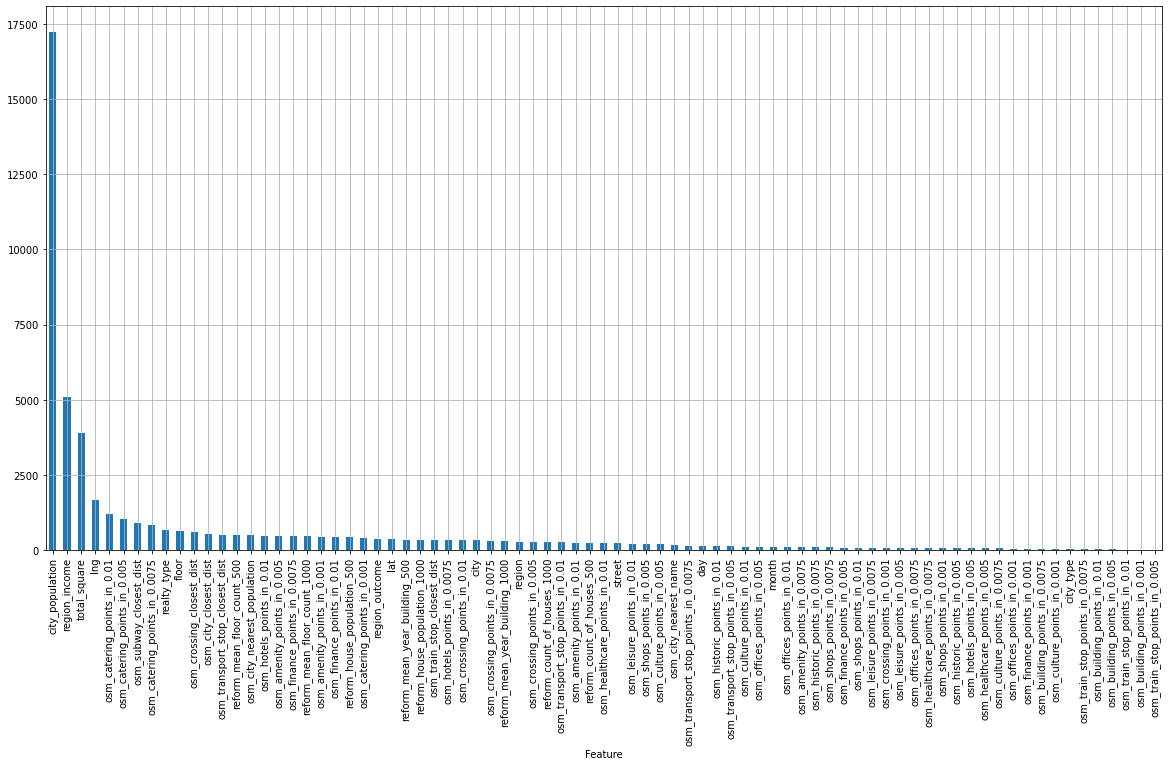

In [73]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [74]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(deviation_metric_vec(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

[2021-09-26 04:02:57,603] (INFO): Prediction for test data:
array([[43269.832],
       [43796.27 ],
       [43471.48 ],
       ...,
       [44085.28 ],
       [45623.965],
       [49662.723]], dtype=float32)
Shape = (2974, 1)
[2021-09-26 04:02:57,607] (INFO): Check scores...
[2021-09-26 04:02:57,612] (INFO): OOF score: 1.2675701244714326


CPU times: user 4.87 s, sys: 45 ms, total: 4.91 s
Wall time: 3.23 s


In [75]:
submission_data[TARGET_NAME] = test_pred.data[:, 0]
submission_data.head()

,id,per_square_meter_price
0,COL_289284,43269.832031
1,COL_289305,43796.269531
2,COL_289318,43471.480469
3,COL_289354,95849.359375
4,COL_289399,50067.832031


In [ ]:
# submission_data.to_csv('found404_submission_14.csv', sep=',', header=True, index=False)

In [76]:
# output = pd.DataFrame({'id': test_data['id'],
#                        'per_square_meter_price': automl.predict(test_data).data[:, 0]})
submission_data['per_square_meter_price'] = submission_data['per_square_meter_price'] * 0.9

submission_data.loc[submission_data['per_square_meter_price'] >= 200000, 'per_square_meter_price'] \
    = submission_data.loc[submission_data['per_square_meter_price'] >= 200000, 'per_square_meter_price'] * 0.9

submission_data.to_csv('found404_submission_26.csv', sep=',', header=True, index=False)

In [ ]:
%%time

train_pred = automl.predict(train_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(train_pred, train_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(deviation_metric_vec(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

[2021-09-26 00:35:18,761] (INFO): Prediction for test data:
array([[96977.59 ],
       [31687.75 ],
       [72711.22 ],
       ...,
       [37647.89 ],
       [47707.867],
       [43002.957]], dtype=float32)
Shape = (4493, 1)
[2021-09-26 00:35:18,762] (INFO): Check scores...
[2021-09-26 00:35:18,765] (INFO): OOF score: 1.2631628498549057


CPU times: user 10.9 s, sys: 49.1 ms, total: 10.9 s
Wall time: 6.94 s


In [ ]:
train_predict_df = pd.DataFrame()
train_predict_df['per_square_meter_price'] = train_pred.data[:, 0]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn') 

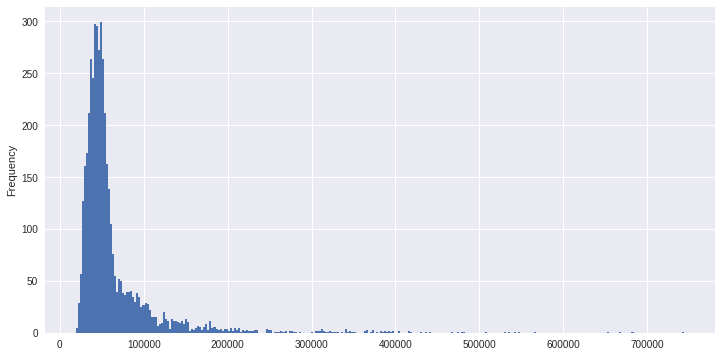

In [ ]:
plt.figure(figsize=(12, 6))
train_predict_df.per_square_meter_price.plot.hist(bins=300)

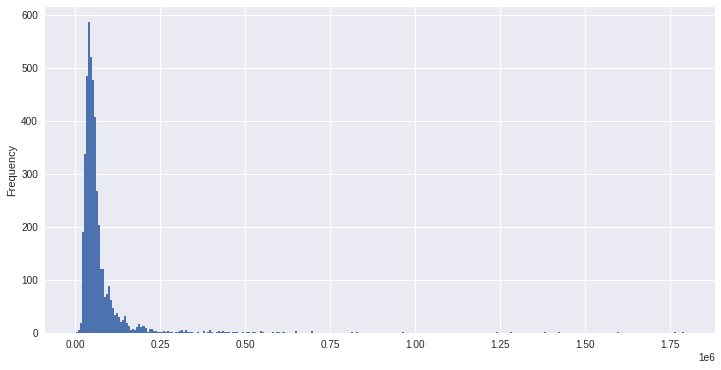

In [ ]:
plt.figure(figsize=(12, 6))
train_data.per_square_meter_price.plot.hist(bins=300)

In [ ]:
m1 = train_data.per_square_meter_price.median()
m2 = submission_data.per_square_meter_price.median()
(m1 - m2) / m1

0.1425566428305818

In [ ]:
1 lightgbm на их метрике, на ооф дал 7 с копейкой
2 lightgbm со стандартной метрикой дал 3.1490033770612937
3 lightgbm tuned со стандартной метрикой дал 3.135785845671798
4 catboost со стандартной метрикой дал 3.3419913332780804
5 catboost с их метрикой дал 3.3419913332780804 (такой же, да странно, да пиздец, не сохранял результат - идентичен 4 csv-шке)
6 ['lgb_tuned'], ['lgb_tuned'] стекинг со стандартной метрикой дал 3.135785845671798 (какая-то фигня с метрикой)

--------------
25.09
--------------
7 мы попробовали предобработать floor и заранить это на lgb, получили 3.0196769072998917
8 оставляем все так же, lgb, но увеличить время с 3200 секунд до 4500 секунд, получили 2.968022016820524
  можно также проверить, что будет, если тест разделить на 0,88 (смещение результата) ---
9 решили попроовать по рекомендации Александра взять АвтоМЛ с новой метрикой, другим таском и заранить это на 1 слое с lgb_tuned 2.6950921244578594
10 решили проверить, что будет если брать только данные с price_type=1, на 1 слое с lgb_tuned получили 1.391352224230633
11 решили проверить отдельно cb_tuned на тех же услоивиях , что и в пред случа, получили 1.426736
12 блендинг cb_tuned и lgb_tuned дал 1.379500973668046